In [9]:
import os
import os.path as osp
def find_root_folder(starting_path = os.getcwd()):
    from os.path import isfile, join, dirname
    path = starting_path
    i = 0
    found = False
    while i < 100:
        found = ('LICENSE' in [f for f in os.listdir(path) if isfile(join(path, f))])
        if found:
            break
        else:
            i += 1
            print(path)
            path = dirname(path)            
    if found:
        print(f"Found directory with license at {path}")
    else:
        raise FileNotFoundError("Could not find LICENSE file in ancestral directory")
    return path
ROOT_FOLDER = find_root_folder()
DS_FOLDER = osp.join(ROOT_FOLDER,'kddbr-2022')


# Arguments. Some are unused
DEVICE = 'cuda'
FOLD_SPLITS = 10
WHICH_VAL_FOLD = 0
RANDOM_STATE = 123
DEBUG = False
BATCH_SIZE = 128
NUM_EPOCHS = 200
VAL_EPOCH = 5



Found directory with license at /home/klaus/eclipse_draft/KDD2022_github


In [10]:
import os

import cv2 as cv
import torch
import pandas as pd
import os.path as osp
import numpy as np
import torchvision
from torchvision.transforms import Normalize
from torch import tensor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

"""
Dataframe setup
"""
import sklearn
from sklearn.model_selection import KFold
def setup_dataframes():
    df = pd.read_csv(osp.join(DS_FOLDER, 'public.csv'))
    df_test, df_train = df[pd.isna(df.East)].reset_index(drop=True), df[~pd.isna(df.East)].reset_index(drop=True)
    df_trainval = df_train.copy()
    del df
    # Use K-Fold to separate between training and test
    kf = KFold(n_splits=FOLD_SPLITS,shuffle=True,random_state=RANDOM_STATE)
    N_trainval = df_train.shape[0]
    for i,(train_idx, val_idx) in enumerate(kf.split(np.arange(N_trainval)[:,None])):
        if i == WHICH_VAL_FOLD:
            df_val = df_train.loc[val_idx,:].reset_index(drop=True)
            df_train = df_train.loc[train_idx,:].reset_index(drop=True)

    return {'train': df_train, 'val':df_val, 'test':df_test, 'trainval':df_trainval}


#  Get Dataframe dictionary
dfs = setup_dataframes()


In [11]:
display(dfs['test'])

,Filename,Altitude,Delta,North,East
0,000053b1e684c9e7ea73727b2238ce18.jpg,167.943069,0.010269,NaN,NaN
1,00029153d12ae1c9abe59c17ff2e0895.jpg,195.853088,0.089218,NaN,NaN
2,0006246bee639c7a7b11a08e34dd3cc6.jpg,146.943466,-0.018326,NaN,NaN
3,00063cb5da1826febf178b669eea3250.jpg,213.184418,-0.108704,NaN,NaN
4,00063ece2e68a8847f228e8fd922f851.jpg,184.757767,0.017700,NaN,NaN
...,...,...,...,...,...
55026,fff87fc38496c1838a216c742e653065.jpg,191.309677,-0.509415,NaN,NaN
55027,fff98e721ed96517d940eb5b2daf2d18.jpg,171.288254,0.109970,NaN,NaN
55028,fff9e3be29d11366c43df7b2ae749547.jpg,196.589905,-0.118561,NaN,NaN
55029,fffae68750a8bd5e6ba46b25ce7030de.jpg,176.795364,0.023209,NaN,NaN


/tmp/ipykernel_10405/4231715049.py:23: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
/tmp/ipykernel_10405/4231715049.py:23: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
100%|████████████████████████████████| 410540/410540 [00:14<00:00, 29206.57it/s]


Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47642
[LightGBM] [Info] Number of data points in the train set: 82108, number of used features: 195
[LightGBM] [Info] Start training from score -0.009570
[1]	training's rmse: 1.20188	valid_1's rmse: 1.02907
[2]	training's rmse: 1.19652	valid_1's rmse: 1.02472
[3]	training's rmse: 1.19117	valid_1's rmse: 1.02035
[4]	training's rmse: 1.18588	valid_1's rmse: 1.01597
[5]	training's rmse: 1.18058	valid_1's rmse: 1.01166
[6]	training's rmse: 1.17529	valid_1's rmse: 1.00735
[7]	training's rmse: 1.17005	valid_1's rmse: 1.003
[8]	training's rmse: 1.16481	valid_1's rmse: 0.998706
[9]	training's rmse: 1.15961	valid_1's rmse: 0.994509
[10]	training's rmse: 1.15445	valid_1's rmse: 0.990337
[11]	training's rmse: 1.1493	valid_1's rmse: 0.986219
[12]	training's rmse: 1.14418	valid_1's rmse:

[151]	training's rmse: 0.647863	valid_1's rmse: 0.584095
[152]	training's rmse: 0.645493	valid_1's rmse: 0.582314
[153]	training's rmse: 0.64312	valid_1's rmse: 0.58039
[154]	training's rmse: 0.640792	valid_1's rmse: 0.578556
[155]	training's rmse: 0.638478	valid_1's rmse: 0.576707
[156]	training's rmse: 0.636164	valid_1's rmse: 0.574987
[157]	training's rmse: 0.633867	valid_1's rmse: 0.573261
[158]	training's rmse: 0.631638	valid_1's rmse: 0.571468
[159]	training's rmse: 0.629371	valid_1's rmse: 0.569738
[160]	training's rmse: 0.627137	valid_1's rmse: 0.568059
[161]	training's rmse: 0.624868	valid_1's rmse: 0.566248
[162]	training's rmse: 0.622618	valid_1's rmse: 0.564606
[163]	training's rmse: 0.620374	valid_1's rmse: 0.562946
[164]	training's rmse: 0.618169	valid_1's rmse: 0.561296
[165]	training's rmse: 0.615958	valid_1's rmse: 0.559721
[166]	training's rmse: 0.613773	valid_1's rmse: 0.557994
[167]	training's rmse: 0.611612	valid_1's rmse: 0.556264
[168]	training's rmse: 0.609476	v

[309]	training's rmse: 0.404954	valid_1's rmse: 0.407691
[310]	training's rmse: 0.404025	valid_1's rmse: 0.407041
[311]	training's rmse: 0.403091	valid_1's rmse: 0.406413
[312]	training's rmse: 0.402171	valid_1's rmse: 0.405831
[313]	training's rmse: 0.401271	valid_1's rmse: 0.405218
[314]	training's rmse: 0.400346	valid_1's rmse: 0.404679
[315]	training's rmse: 0.399426	valid_1's rmse: 0.404048
[316]	training's rmse: 0.398564	valid_1's rmse: 0.403444
[317]	training's rmse: 0.397681	valid_1's rmse: 0.40281
[318]	training's rmse: 0.396825	valid_1's rmse: 0.402203
[319]	training's rmse: 0.395977	valid_1's rmse: 0.401654
[320]	training's rmse: 0.395119	valid_1's rmse: 0.401072
[321]	training's rmse: 0.394252	valid_1's rmse: 0.400454
[322]	training's rmse: 0.393396	valid_1's rmse: 0.39984
[323]	training's rmse: 0.392564	valid_1's rmse: 0.399251
[324]	training's rmse: 0.391724	valid_1's rmse: 0.398684
[325]	training's rmse: 0.390917	valid_1's rmse: 0.398144
[326]	training's rmse: 0.390072	v

[471]	training's rmse: 0.309503	valid_1's rmse: 0.345626
[472]	training's rmse: 0.309133	valid_1's rmse: 0.345411
[473]	training's rmse: 0.308789	valid_1's rmse: 0.345214
[474]	training's rmse: 0.308442	valid_1's rmse: 0.345022
[475]	training's rmse: 0.308099	valid_1's rmse: 0.344813
[476]	training's rmse: 0.307762	valid_1's rmse: 0.344626
[477]	training's rmse: 0.307434	valid_1's rmse: 0.344441
[478]	training's rmse: 0.307097	valid_1's rmse: 0.344245
[479]	training's rmse: 0.306769	valid_1's rmse: 0.344075
[480]	training's rmse: 0.306425	valid_1's rmse: 0.343871
[481]	training's rmse: 0.306098	valid_1's rmse: 0.343693
[482]	training's rmse: 0.305773	valid_1's rmse: 0.343506
[483]	training's rmse: 0.305447	valid_1's rmse: 0.34329
[484]	training's rmse: 0.305119	valid_1's rmse: 0.343078
[485]	training's rmse: 0.304783	valid_1's rmse: 0.342822
[486]	training's rmse: 0.304417	valid_1's rmse: 0.342603
[487]	training's rmse: 0.304061	valid_1's rmse: 0.342423
[488]	training's rmse: 0.303714	

[624]	training's rmse: 0.26966	valid_1's rmse: 0.324864
[625]	training's rmse: 0.269492	valid_1's rmse: 0.324742
[626]	training's rmse: 0.269313	valid_1's rmse: 0.324652
[627]	training's rmse: 0.269128	valid_1's rmse: 0.324569
[628]	training's rmse: 0.268961	valid_1's rmse: 0.324505
[629]	training's rmse: 0.26878	valid_1's rmse: 0.324433
[630]	training's rmse: 0.26859	valid_1's rmse: 0.32434
[631]	training's rmse: 0.268422	valid_1's rmse: 0.324252
[632]	training's rmse: 0.268259	valid_1's rmse: 0.324149
[633]	training's rmse: 0.268082	valid_1's rmse: 0.324055
[634]	training's rmse: 0.267919	valid_1's rmse: 0.323859
[635]	training's rmse: 0.267742	valid_1's rmse: 0.323746
[636]	training's rmse: 0.267567	valid_1's rmse: 0.323656
[637]	training's rmse: 0.267411	valid_1's rmse: 0.323556
[638]	training's rmse: 0.267238	valid_1's rmse: 0.323497
[639]	training's rmse: 0.267083	valid_1's rmse: 0.323432
[640]	training's rmse: 0.266927	valid_1's rmse: 0.323341
[641]	training's rmse: 0.266717	val

[780]	training's rmse: 0.247707	valid_1's rmse: 0.314984
[781]	training's rmse: 0.247604	valid_1's rmse: 0.314912
[782]	training's rmse: 0.247496	valid_1's rmse: 0.314856
[783]	training's rmse: 0.247396	valid_1's rmse: 0.3148
[784]	training's rmse: 0.247302	valid_1's rmse: 0.314745
[785]	training's rmse: 0.247214	valid_1's rmse: 0.314649
[786]	training's rmse: 0.24708	valid_1's rmse: 0.314594
[787]	training's rmse: 0.246944	valid_1's rmse: 0.314511
[788]	training's rmse: 0.246814	valid_1's rmse: 0.31445
[789]	training's rmse: 0.246677	valid_1's rmse: 0.314396
[790]	training's rmse: 0.246556	valid_1's rmse: 0.314342
[791]	training's rmse: 0.246458	valid_1's rmse: 0.31429
[792]	training's rmse: 0.246362	valid_1's rmse: 0.314234
[793]	training's rmse: 0.246256	valid_1's rmse: 0.314195
[794]	training's rmse: 0.246154	valid_1's rmse: 0.314109
[795]	training's rmse: 0.246058	valid_1's rmse: 0.31408
[796]	training's rmse: 0.245947	valid_1's rmse: 0.314052
[797]	training's rmse: 0.245832	valid

[940]	training's rmse: 0.232045	valid_1's rmse: 0.308071
[941]	training's rmse: 0.231941	valid_1's rmse: 0.308013
[942]	training's rmse: 0.231838	valid_1's rmse: 0.30798
[943]	training's rmse: 0.23174	valid_1's rmse: 0.307947
[944]	training's rmse: 0.231642	valid_1's rmse: 0.307907
[945]	training's rmse: 0.231542	valid_1's rmse: 0.307893
[946]	training's rmse: 0.231448	valid_1's rmse: 0.307859
[947]	training's rmse: 0.231356	valid_1's rmse: 0.307805
[948]	training's rmse: 0.231266	valid_1's rmse: 0.30779
[949]	training's rmse: 0.231174	valid_1's rmse: 0.307762
[950]	training's rmse: 0.231098	valid_1's rmse: 0.307727
[951]	training's rmse: 0.230992	valid_1's rmse: 0.307687
[952]	training's rmse: 0.230876	valid_1's rmse: 0.30766
[953]	training's rmse: 0.230762	valid_1's rmse: 0.30765
[954]	training's rmse: 0.23065	valid_1's rmse: 0.30761
[955]	training's rmse: 0.230549	valid_1's rmse: 0.307574
[956]	training's rmse: 0.230444	valid_1's rmse: 0.307537
[957]	training's rmse: 0.230353	valid_

[1085]	training's rmse: 0.220274	valid_1's rmse: 0.303647
[1086]	training's rmse: 0.220186	valid_1's rmse: 0.303577
[1087]	training's rmse: 0.220096	valid_1's rmse: 0.303524
[1088]	training's rmse: 0.220008	valid_1's rmse: 0.303504
[1089]	training's rmse: 0.21992	valid_1's rmse: 0.30348
[1090]	training's rmse: 0.21983	valid_1's rmse: 0.30346
[1091]	training's rmse: 0.219778	valid_1's rmse: 0.303417
[1092]	training's rmse: 0.219727	valid_1's rmse: 0.303383
[1093]	training's rmse: 0.219676	valid_1's rmse: 0.303338
[1094]	training's rmse: 0.219619	valid_1's rmse: 0.303298
[1095]	training's rmse: 0.219561	valid_1's rmse: 0.303262
[1096]	training's rmse: 0.219489	valid_1's rmse: 0.303236
[1097]	training's rmse: 0.219423	valid_1's rmse: 0.3032
[1098]	training's rmse: 0.21934	valid_1's rmse: 0.303192
[1099]	training's rmse: 0.219251	valid_1's rmse: 0.30319
[1100]	training's rmse: 0.219179	valid_1's rmse: 0.303184
[1101]	training's rmse: 0.219123	valid_1's rmse: 0.303157
[1102]	training's rmse

[1233]	training's rmse: 0.211094	valid_1's rmse: 0.300756
[1234]	training's rmse: 0.211004	valid_1's rmse: 0.300771
[1235]	training's rmse: 0.210926	valid_1's rmse: 0.300736
[1236]	training's rmse: 0.210858	valid_1's rmse: 0.300716
[1237]	training's rmse: 0.210778	valid_1's rmse: 0.300747
[1238]	training's rmse: 0.210706	valid_1's rmse: 0.300742
[1239]	training's rmse: 0.210633	valid_1's rmse: 0.300723
[1240]	training's rmse: 0.210555	valid_1's rmse: 0.300716
[1241]	training's rmse: 0.210504	valid_1's rmse: 0.300701
[1242]	training's rmse: 0.210446	valid_1's rmse: 0.300674
[1243]	training's rmse: 0.210396	valid_1's rmse: 0.300647
[1244]	training's rmse: 0.210339	valid_1's rmse: 0.300636
[1245]	training's rmse: 0.210286	valid_1's rmse: 0.300645
[1246]	training's rmse: 0.210231	valid_1's rmse: 0.300647
[1247]	training's rmse: 0.210178	valid_1's rmse: 0.300636
[1248]	training's rmse: 0.210131	valid_1's rmse: 0.300623
[1249]	training's rmse: 0.210084	valid_1's rmse: 0.300606
[1250]	trainin

[1380]	training's rmse: 0.203383	valid_1's rmse: 0.299313
[1381]	training's rmse: 0.203343	valid_1's rmse: 0.299307
[1382]	training's rmse: 0.203308	valid_1's rmse: 0.299299
[1383]	training's rmse: 0.203267	valid_1's rmse: 0.299282
[1384]	training's rmse: 0.203223	valid_1's rmse: 0.299272
[1385]	training's rmse: 0.203182	valid_1's rmse: 0.299247
[1386]	training's rmse: 0.203147	valid_1's rmse: 0.299241
[1387]	training's rmse: 0.203115	valid_1's rmse: 0.299228
[1388]	training's rmse: 0.20308	valid_1's rmse: 0.299213
[1389]	training's rmse: 0.203045	valid_1's rmse: 0.299205
[1390]	training's rmse: 0.203011	valid_1's rmse: 0.299201
[1391]	training's rmse: 0.202935	valid_1's rmse: 0.299234
[1392]	training's rmse: 0.202858	valid_1's rmse: 0.299265
[1393]	training's rmse: 0.202783	valid_1's rmse: 0.299301
[1394]	training's rmse: 0.20272	valid_1's rmse: 0.299291
[1395]	training's rmse: 0.202645	valid_1's rmse: 0.299326
[1396]	training's rmse: 0.202611	valid_1's rmse: 0.299326
[1397]	training'

[1530]	training's rmse: 0.195984	valid_1's rmse: 0.298209
[1531]	training's rmse: 0.195939	valid_1's rmse: 0.298203
[1532]	training's rmse: 0.195898	valid_1's rmse: 0.298201
[1533]	training's rmse: 0.195859	valid_1's rmse: 0.298189
[1534]	training's rmse: 0.195824	valid_1's rmse: 0.298193
[1535]	training's rmse: 0.195787	valid_1's rmse: 0.29819
[1536]	training's rmse: 0.195746	valid_1's rmse: 0.298196
[1537]	training's rmse: 0.195703	valid_1's rmse: 0.298186
[1538]	training's rmse: 0.195664	valid_1's rmse: 0.298174
[1539]	training's rmse: 0.195626	valid_1's rmse: 0.298163
[1540]	training's rmse: 0.195583	valid_1's rmse: 0.298182
[1541]	training's rmse: 0.195518	valid_1's rmse: 0.298183
[1542]	training's rmse: 0.195453	valid_1's rmse: 0.298187
[1543]	training's rmse: 0.19539	valid_1's rmse: 0.298172
[1544]	training's rmse: 0.195324	valid_1's rmse: 0.298176
[1545]	training's rmse: 0.195248	valid_1's rmse: 0.298192
[1546]	training's rmse: 0.195176	valid_1's rmse: 0.298236
[1547]	training'

[1683]	training's rmse: 0.188824	valid_1's rmse: 0.297458
[1684]	training's rmse: 0.188782	valid_1's rmse: 0.297447
[1685]	training's rmse: 0.188744	valid_1's rmse: 0.297441
[1686]	training's rmse: 0.188702	valid_1's rmse: 0.297418
[1687]	training's rmse: 0.188655	valid_1's rmse: 0.297395
[1688]	training's rmse: 0.188614	valid_1's rmse: 0.297386
[1689]	training's rmse: 0.188577	valid_1's rmse: 0.297368
[1690]	training's rmse: 0.188538	valid_1's rmse: 0.297348
[1691]	training's rmse: 0.18851	valid_1's rmse: 0.297348
[1692]	training's rmse: 0.188478	valid_1's rmse: 0.297344
[1693]	training's rmse: 0.188449	valid_1's rmse: 0.297346
[1694]	training's rmse: 0.188423	valid_1's rmse: 0.297337
[1695]	training's rmse: 0.188396	valid_1's rmse: 0.297317
[1696]	training's rmse: 0.188334	valid_1's rmse: 0.297297
[1697]	training's rmse: 0.18827	valid_1's rmse: 0.29731
[1698]	training's rmse: 0.18821	valid_1's rmse: 0.297303
[1699]	training's rmse: 0.188156	valid_1's rmse: 0.297293
[1700]	training's 

[1834]	training's rmse: 0.18275	valid_1's rmse: 0.297175
[1835]	training's rmse: 0.182708	valid_1's rmse: 0.297178
[1836]	training's rmse: 0.18269	valid_1's rmse: 0.297169
[1837]	training's rmse: 0.182669	valid_1's rmse: 0.297162
[1838]	training's rmse: 0.182642	valid_1's rmse: 0.297159
[1839]	training's rmse: 0.182622	valid_1's rmse: 0.29715
[1840]	training's rmse: 0.182595	valid_1's rmse: 0.297158
[1841]	training's rmse: 0.182564	valid_1's rmse: 0.297176
[1842]	training's rmse: 0.182529	valid_1's rmse: 0.297163
[1843]	training's rmse: 0.182497	valid_1's rmse: 0.297178
[1844]	training's rmse: 0.182469	valid_1's rmse: 0.297192
[1845]	training's rmse: 0.182443	valid_1's rmse: 0.297172
[1846]	training's rmse: 0.182409	valid_1's rmse: 0.297169
[1847]	training's rmse: 0.182376	valid_1's rmse: 0.29717
[1848]	training's rmse: 0.182341	valid_1's rmse: 0.297166
[1849]	training's rmse: 0.182312	valid_1's rmse: 0.297133
[1850]	training's rmse: 0.182277	valid_1's rmse: 0.297134
[1851]	training's 

[1983]	training's rmse: 0.177356	valid_1's rmse: 0.296539
[1984]	training's rmse: 0.1773	valid_1's rmse: 0.296524
[1985]	training's rmse: 0.177247	valid_1's rmse: 0.296519
[1986]	training's rmse: 0.177225	valid_1's rmse: 0.296516
[1987]	training's rmse: 0.177199	valid_1's rmse: 0.296507
[1988]	training's rmse: 0.177175	valid_1's rmse: 0.296502
[1989]	training's rmse: 0.177151	valid_1's rmse: 0.296492
[1990]	training's rmse: 0.177122	valid_1's rmse: 0.29648
[1991]	training's rmse: 0.177103	valid_1's rmse: 0.296481
[1992]	training's rmse: 0.177078	valid_1's rmse: 0.296482
[1993]	training's rmse: 0.177051	valid_1's rmse: 0.296482
[1994]	training's rmse: 0.177022	valid_1's rmse: 0.296476
[1995]	training's rmse: 0.176995	valid_1's rmse: 0.296478
[1996]	training's rmse: 0.176958	valid_1's rmse: 0.296484
[1997]	training's rmse: 0.176923	valid_1's rmse: 0.296482
[1998]	training's rmse: 0.176886	valid_1's rmse: 0.296468
[1999]	training's rmse: 0.176848	valid_1's rmse: 0.296456
[2000]	training's

[2134]	training's rmse: 0.172408	valid_1's rmse: 0.295909
[2135]	training's rmse: 0.172377	valid_1's rmse: 0.295905
[2136]	training's rmse: 0.172344	valid_1's rmse: 0.295903
[2137]	training's rmse: 0.172314	valid_1's rmse: 0.2959
[2138]	training's rmse: 0.172276	valid_1's rmse: 0.29589
[2139]	training's rmse: 0.172247	valid_1's rmse: 0.295887
[2140]	training's rmse: 0.172218	valid_1's rmse: 0.295884
[2141]	training's rmse: 0.172193	valid_1's rmse: 0.295872
[2142]	training's rmse: 0.172168	valid_1's rmse: 0.295856
[2143]	training's rmse: 0.172142	valid_1's rmse: 0.295845
[2144]	training's rmse: 0.172119	valid_1's rmse: 0.295841
[2145]	training's rmse: 0.172094	valid_1's rmse: 0.295839
[2146]	training's rmse: 0.172072	valid_1's rmse: 0.295848
[2147]	training's rmse: 0.17205	valid_1's rmse: 0.295842
[2148]	training's rmse: 0.172032	valid_1's rmse: 0.295841
[2149]	training's rmse: 0.172008	valid_1's rmse: 0.295837
[2150]	training's rmse: 0.17198	valid_1's rmse: 0.29584
[2151]	training's rm

[2284]	training's rmse: 0.167256	valid_1's rmse: 0.295874
[2285]	training's rmse: 0.167237	valid_1's rmse: 0.29587
[2286]	training's rmse: 0.167209	valid_1's rmse: 0.295848
[2287]	training's rmse: 0.167185	valid_1's rmse: 0.295834
[2288]	training's rmse: 0.167166	valid_1's rmse: 0.295827
[2289]	training's rmse: 0.167145	valid_1's rmse: 0.295823
[2290]	training's rmse: 0.167121	valid_1's rmse: 0.295822
[2291]	training's rmse: 0.167095	valid_1's rmse: 0.295817
[2292]	training's rmse: 0.167072	valid_1's rmse: 0.295807
[2293]	training's rmse: 0.167053	valid_1's rmse: 0.295799
[2294]	training's rmse: 0.167027	valid_1's rmse: 0.295794
[2295]	training's rmse: 0.16701	valid_1's rmse: 0.295797
[2296]	training's rmse: 0.166956	valid_1's rmse: 0.295769
[2297]	training's rmse: 0.166903	valid_1's rmse: 0.295746
[2298]	training's rmse: 0.166858	valid_1's rmse: 0.295732
[2299]	training's rmse: 0.166813	valid_1's rmse: 0.295719
[2300]	training's rmse: 0.166757	valid_1's rmse: 0.295751
[2301]	training'

[2437]	training's rmse: 0.162323	valid_1's rmse: 0.296119
[2438]	training's rmse: 0.162278	valid_1's rmse: 0.296181
[2439]	training's rmse: 0.162233	valid_1's rmse: 0.29618
[2440]	training's rmse: 0.162186	valid_1's rmse: 0.296227
[2441]	training's rmse: 0.162163	valid_1's rmse: 0.296223
[2442]	training's rmse: 0.162145	valid_1's rmse: 0.296215
[2443]	training's rmse: 0.162122	valid_1's rmse: 0.296208
[2444]	training's rmse: 0.1621	valid_1's rmse: 0.296201
[2445]	training's rmse: 0.162081	valid_1's rmse: 0.296201
[2446]	training's rmse: 0.162039	valid_1's rmse: 0.296197
[2447]	training's rmse: 0.161989	valid_1's rmse: 0.29626
[2448]	training's rmse: 0.161941	valid_1's rmse: 0.296256
[2449]	training's rmse: 0.161897	valid_1's rmse: 0.296239
[2450]	training's rmse: 0.161856	valid_1's rmse: 0.296233
[2451]	training's rmse: 0.161825	valid_1's rmse: 0.29623
[2452]	training's rmse: 0.161791	valid_1's rmse: 0.296211
[2453]	training's rmse: 0.16176	valid_1's rmse: 0.296202
[2454]	training's rm

[2587]	training's rmse: 0.158262	valid_1's rmse: 0.295333
[2588]	training's rmse: 0.158215	valid_1's rmse: 0.295371
[2589]	training's rmse: 0.158172	valid_1's rmse: 0.29536
[2590]	training's rmse: 0.158133	valid_1's rmse: 0.295351
[2591]	training's rmse: 0.158118	valid_1's rmse: 0.295338
[2592]	training's rmse: 0.1581	valid_1's rmse: 0.295328
[2593]	training's rmse: 0.158083	valid_1's rmse: 0.295322
[2594]	training's rmse: 0.158063	valid_1's rmse: 0.295319
[2595]	training's rmse: 0.158045	valid_1's rmse: 0.295319
[2596]	training's rmse: 0.158026	valid_1's rmse: 0.295338
[2597]	training's rmse: 0.158006	valid_1's rmse: 0.295337
[2598]	training's rmse: 0.157984	valid_1's rmse: 0.295371
[2599]	training's rmse: 0.157965	valid_1's rmse: 0.295368
[2600]	training's rmse: 0.157941	valid_1's rmse: 0.295363
[2601]	training's rmse: 0.157922	valid_1's rmse: 0.295343
[2602]	training's rmse: 0.157902	valid_1's rmse: 0.29534
[2603]	training's rmse: 0.15788	valid_1's rmse: 0.295328
[2604]	training's r

[2736]	training's rmse: 0.154327	valid_1's rmse: 0.294917
[2737]	training's rmse: 0.154315	valid_1's rmse: 0.294919
[2738]	training's rmse: 0.1543	valid_1's rmse: 0.294916
[2739]	training's rmse: 0.154283	valid_1's rmse: 0.294906
[2740]	training's rmse: 0.154267	valid_1's rmse: 0.294909
[2741]	training's rmse: 0.154222	valid_1's rmse: 0.294914
[2742]	training's rmse: 0.154181	valid_1's rmse: 0.294912
[2743]	training's rmse: 0.154136	valid_1's rmse: 0.294919
[2744]	training's rmse: 0.15409	valid_1's rmse: 0.294969
[2745]	training's rmse: 0.154046	valid_1's rmse: 0.294974
[2746]	training's rmse: 0.154019	valid_1's rmse: 0.294968
[2747]	training's rmse: 0.153997	valid_1's rmse: 0.294963
[2748]	training's rmse: 0.153975	valid_1's rmse: 0.294947
[2749]	training's rmse: 0.153954	valid_1's rmse: 0.294938
[2750]	training's rmse: 0.153933	valid_1's rmse: 0.294927
[2751]	training's rmse: 0.153921	valid_1's rmse: 0.294926
[2752]	training's rmse: 0.153893	valid_1's rmse: 0.294904
[2753]	training's

[2888]	training's rmse: 0.150344	valid_1's rmse: 0.295012
[2889]	training's rmse: 0.15031	valid_1's rmse: 0.29501
[2890]	training's rmse: 0.150273	valid_1's rmse: 0.295055
[2891]	training's rmse: 0.150248	valid_1's rmse: 0.295047
[2892]	training's rmse: 0.150225	valid_1's rmse: 0.29505
[2893]	training's rmse: 0.150192	valid_1's rmse: 0.295037
[2894]	training's rmse: 0.150166	valid_1's rmse: 0.295022
[2895]	training's rmse: 0.150133	valid_1's rmse: 0.295014
[2896]	training's rmse: 0.150094	valid_1's rmse: 0.295008
[2897]	training's rmse: 0.150055	valid_1's rmse: 0.295007
[2898]	training's rmse: 0.150013	valid_1's rmse: 0.295009
[2899]	training's rmse: 0.149973	valid_1's rmse: 0.295075
[2900]	training's rmse: 0.149931	valid_1's rmse: 0.295064
[2901]	training's rmse: 0.1499	valid_1's rmse: 0.295072
[2902]	training's rmse: 0.149872	valid_1's rmse: 0.295068
[2903]	training's rmse: 0.149845	valid_1's rmse: 0.295065
[2904]	training's rmse: 0.149822	valid_1's rmse: 0.29506
[2905]	training's rm

[3039]	training's rmse: 0.146311	valid_1's rmse: 0.294854
[3040]	training's rmse: 0.14627	valid_1's rmse: 0.294856
[3041]	training's rmse: 0.146253	valid_1's rmse: 0.294855
[3042]	training's rmse: 0.146234	valid_1's rmse: 0.294854
[3043]	training's rmse: 0.146216	valid_1's rmse: 0.294847
[3044]	training's rmse: 0.146199	valid_1's rmse: 0.294855
[3045]	training's rmse: 0.146181	valid_1's rmse: 0.294849
[3046]	training's rmse: 0.146153	valid_1's rmse: 0.294836
[3047]	training's rmse: 0.146121	valid_1's rmse: 0.294826
[3048]	training's rmse: 0.146095	valid_1's rmse: 0.294814
[3049]	training's rmse: 0.146067	valid_1's rmse: 0.294812
[3050]	training's rmse: 0.146042	valid_1's rmse: 0.294804
[3051]	training's rmse: 0.146029	valid_1's rmse: 0.2948
[3052]	training's rmse: 0.146011	valid_1's rmse: 0.294769
[3053]	training's rmse: 0.145994	valid_1's rmse: 0.294751
[3054]	training's rmse: 0.145977	valid_1's rmse: 0.294722
[3055]	training's rmse: 0.145964	valid_1's rmse: 0.294712
[3056]	training's

[3190]	training's rmse: 0.142821	valid_1's rmse: 0.294719
[3191]	training's rmse: 0.142788	valid_1's rmse: 0.294709
[3192]	training's rmse: 0.142752	valid_1's rmse: 0.294693
[3193]	training's rmse: 0.142717	valid_1's rmse: 0.294692
[3194]	training's rmse: 0.14268	valid_1's rmse: 0.294687
[3195]	training's rmse: 0.142645	valid_1's rmse: 0.294679
[3196]	training's rmse: 0.142602	valid_1's rmse: 0.29474
[3197]	training's rmse: 0.14256	valid_1's rmse: 0.294792
[3198]	training's rmse: 0.142527	valid_1's rmse: 0.294789
[3199]	training's rmse: 0.142493	valid_1's rmse: 0.294789
[3200]	training's rmse: 0.142455	valid_1's rmse: 0.294848
[3201]	training's rmse: 0.142425	valid_1's rmse: 0.294828
[3202]	training's rmse: 0.142402	valid_1's rmse: 0.294818
[3203]	training's rmse: 0.142374	valid_1's rmse: 0.2948
[3204]	training's rmse: 0.142351	valid_1's rmse: 0.294782
[3205]	training's rmse: 0.142327	valid_1's rmse: 0.294755
[3206]	training's rmse: 0.142315	valid_1's rmse: 0.294743
[3207]	training's r

[3342]	training's rmse: 0.139144	valid_1's rmse: 0.294649
[3343]	training's rmse: 0.139127	valid_1's rmse: 0.294643
[3344]	training's rmse: 0.13911	valid_1's rmse: 0.294632
[3345]	training's rmse: 0.139086	valid_1's rmse: 0.294625
[3346]	training's rmse: 0.139062	valid_1's rmse: 0.294616
[3347]	training's rmse: 0.139037	valid_1's rmse: 0.294609
[3348]	training's rmse: 0.139014	valid_1's rmse: 0.294602
[3349]	training's rmse: 0.138991	valid_1's rmse: 0.294598
[3350]	training's rmse: 0.138963	valid_1's rmse: 0.294598
[3351]	training's rmse: 0.138944	valid_1's rmse: 0.294593
[3352]	training's rmse: 0.138921	valid_1's rmse: 0.294573
[3353]	training's rmse: 0.138909	valid_1's rmse: 0.294566
[3354]	training's rmse: 0.138887	valid_1's rmse: 0.294557
[3355]	training's rmse: 0.138865	valid_1's rmse: 0.294546
[3356]	training's rmse: 0.13885	valid_1's rmse: 0.294538
[3357]	training's rmse: 0.138822	valid_1's rmse: 0.294533
[3358]	training's rmse: 0.13881	valid_1's rmse: 0.294527
[3359]	training's

[3493]	training's rmse: 0.135828	valid_1's rmse: 0.294194
[3494]	training's rmse: 0.135818	valid_1's rmse: 0.294165
[3495]	training's rmse: 0.135806	valid_1's rmse: 0.294149
[3496]	training's rmse: 0.135781	valid_1's rmse: 0.294145
[3497]	training's rmse: 0.135755	valid_1's rmse: 0.294134
[3498]	training's rmse: 0.135731	valid_1's rmse: 0.294119
[3499]	training's rmse: 0.135705	valid_1's rmse: 0.294117
[3500]	training's rmse: 0.135677	valid_1's rmse: 0.294103
[3501]	training's rmse: 0.135636	valid_1's rmse: 0.294095
[3502]	training's rmse: 0.135598	valid_1's rmse: 0.294147
[3503]	training's rmse: 0.135563	valid_1's rmse: 0.294133
[3504]	training's rmse: 0.135525	valid_1's rmse: 0.294129
[3505]	training's rmse: 0.13549	valid_1's rmse: 0.294119
[3506]	training's rmse: 0.135448	valid_1's rmse: 0.294108
[3507]	training's rmse: 0.135413	valid_1's rmse: 0.294094
[3508]	training's rmse: 0.135369	valid_1's rmse: 0.294086
[3509]	training's rmse: 0.135328	valid_1's rmse: 0.294078
[3510]	training

[3644]	training's rmse: 0.132681	valid_1's rmse: 0.294101
[3645]	training's rmse: 0.13266	valid_1's rmse: 0.294104
[3646]	training's rmse: 0.132638	valid_1's rmse: 0.294134
[3647]	training's rmse: 0.132609	valid_1's rmse: 0.294158
[3648]	training's rmse: 0.132585	valid_1's rmse: 0.294167
[3649]	training's rmse: 0.132553	valid_1's rmse: 0.294207
[3650]	training's rmse: 0.132532	valid_1's rmse: 0.294202
[3651]	training's rmse: 0.132517	valid_1's rmse: 0.294198
[3652]	training's rmse: 0.132501	valid_1's rmse: 0.294199
[3653]	training's rmse: 0.132484	valid_1's rmse: 0.294192
[3654]	training's rmse: 0.132471	valid_1's rmse: 0.294184
[3655]	training's rmse: 0.132455	valid_1's rmse: 0.294178
[3656]	training's rmse: 0.132423	valid_1's rmse: 0.294175
[3657]	training's rmse: 0.132389	valid_1's rmse: 0.294181
[3658]	training's rmse: 0.132358	valid_1's rmse: 0.294171
[3659]	training's rmse: 0.132324	valid_1's rmse: 0.29416
[3660]	training's rmse: 0.132291	valid_1's rmse: 0.294153
[3661]	training'

[3797]	training's rmse: 0.129238	valid_1's rmse: 0.293966
[3798]	training's rmse: 0.129219	valid_1's rmse: 0.293964
[3799]	training's rmse: 0.129192	valid_1's rmse: 0.293952
[3800]	training's rmse: 0.129162	valid_1's rmse: 0.293954
[3801]	training's rmse: 0.129136	valid_1's rmse: 0.293946
[3802]	training's rmse: 0.129111	valid_1's rmse: 0.293941
[3803]	training's rmse: 0.129086	valid_1's rmse: 0.293942
[3804]	training's rmse: 0.12906	valid_1's rmse: 0.293938
[3805]	training's rmse: 0.129039	valid_1's rmse: 0.293934
[3806]	training's rmse: 0.129009	valid_1's rmse: 0.293936
[3807]	training's rmse: 0.128978	valid_1's rmse: 0.293931
[3808]	training's rmse: 0.128949	valid_1's rmse: 0.293925
[3809]	training's rmse: 0.128922	valid_1's rmse: 0.293925
[3810]	training's rmse: 0.128891	valid_1's rmse: 0.293929
[3811]	training's rmse: 0.128865	valid_1's rmse: 0.293972
[3812]	training's rmse: 0.12884	valid_1's rmse: 0.294005
[3813]	training's rmse: 0.128813	valid_1's rmse: 0.294
[3814]	training's r

[3949]	training's rmse: 0.126022	valid_1's rmse: 0.29427
[3950]	training's rmse: 0.12599	valid_1's rmse: 0.29427
[3951]	training's rmse: 0.125969	valid_1's rmse: 0.294268
[3952]	training's rmse: 0.12595	valid_1's rmse: 0.294264
[3953]	training's rmse: 0.125931	valid_1's rmse: 0.29426
[3954]	training's rmse: 0.125912	valid_1's rmse: 0.294263
[3955]	training's rmse: 0.125893	valid_1's rmse: 0.294263
[3956]	training's rmse: 0.125879	valid_1's rmse: 0.294257
[3957]	training's rmse: 0.125866	valid_1's rmse: 0.29425
[3958]	training's rmse: 0.125852	valid_1's rmse: 0.294259
[3959]	training's rmse: 0.125835	valid_1's rmse: 0.29425
[3960]	training's rmse: 0.125825	valid_1's rmse: 0.294248
[3961]	training's rmse: 0.125802	valid_1's rmse: 0.294239
[3962]	training's rmse: 0.125783	valid_1's rmse: 0.294241
[3963]	training's rmse: 0.125759	valid_1's rmse: 0.29423
[3964]	training's rmse: 0.125732	valid_1's rmse: 0.294223
[3965]	training's rmse: 0.125709	valid_1's rmse: 0.294217
[3966]	training's rmse

[4101]	training's rmse: 0.123217	valid_1's rmse: 0.29384
[4102]	training's rmse: 0.12321	valid_1's rmse: 0.293836
[4103]	training's rmse: 0.1232	valid_1's rmse: 0.293834
[4104]	training's rmse: 0.123192	valid_1's rmse: 0.293823
[4105]	training's rmse: 0.123183	valid_1's rmse: 0.29382
[4106]	training's rmse: 0.123173	valid_1's rmse: 0.293819
[4107]	training's rmse: 0.123164	valid_1's rmse: 0.293816
[4108]	training's rmse: 0.123156	valid_1's rmse: 0.29381
[4109]	training's rmse: 0.123145	valid_1's rmse: 0.293809
[4110]	training's rmse: 0.123132	valid_1's rmse: 0.293804
[4111]	training's rmse: 0.123124	valid_1's rmse: 0.293804
[4112]	training's rmse: 0.123111	valid_1's rmse: 0.293802
[4113]	training's rmse: 0.123097	valid_1's rmse: 0.293804
[4114]	training's rmse: 0.123086	valid_1's rmse: 0.293803
[4115]	training's rmse: 0.123074	valid_1's rmse: 0.293802
[4116]	training's rmse: 0.123066	valid_1's rmse: 0.293795
[4117]	training's rmse: 0.123057	valid_1's rmse: 0.293787
[4118]	training's rm

[4255]	training's rmse: 0.12083	valid_1's rmse: 0.293601
[4256]	training's rmse: 0.120812	valid_1's rmse: 0.293601
[4257]	training's rmse: 0.120792	valid_1's rmse: 0.293598
[4258]	training's rmse: 0.120772	valid_1's rmse: 0.293596
[4259]	training's rmse: 0.120752	valid_1's rmse: 0.293597
[4260]	training's rmse: 0.120735	valid_1's rmse: 0.293593
[4261]	training's rmse: 0.120722	valid_1's rmse: 0.293588
[4262]	training's rmse: 0.120707	valid_1's rmse: 0.293586
[4263]	training's rmse: 0.120691	valid_1's rmse: 0.29359
[4264]	training's rmse: 0.120676	valid_1's rmse: 0.293599
[4265]	training's rmse: 0.120663	valid_1's rmse: 0.2936
[4266]	training's rmse: 0.120638	valid_1's rmse: 0.293598
[4267]	training's rmse: 0.120618	valid_1's rmse: 0.293599
[4268]	training's rmse: 0.120597	valid_1's rmse: 0.293598
[4269]	training's rmse: 0.120574	valid_1's rmse: 0.293596
[4270]	training's rmse: 0.120551	valid_1's rmse: 0.293595
[4271]	training's rmse: 0.120541	valid_1's rmse: 0.293593
[4272]	training's 

[4409]	training's rmse: 0.118043	valid_1's rmse: 0.293449
[4410]	training's rmse: 0.118033	valid_1's rmse: 0.293441
[4411]	training's rmse: 0.118025	valid_1's rmse: 0.293436
[4412]	training's rmse: 0.118016	valid_1's rmse: 0.293436
[4413]	training's rmse: 0.118004	valid_1's rmse: 0.293433
[4414]	training's rmse: 0.117997	valid_1's rmse: 0.293425
[4415]	training's rmse: 0.117986	valid_1's rmse: 0.293422
[4416]	training's rmse: 0.117977	valid_1's rmse: 0.293423
[4417]	training's rmse: 0.117967	valid_1's rmse: 0.293419
[4418]	training's rmse: 0.117955	valid_1's rmse: 0.293422
[4419]	training's rmse: 0.117946	valid_1's rmse: 0.293425
[4420]	training's rmse: 0.117936	valid_1's rmse: 0.293424
[4421]	training's rmse: 0.117925	valid_1's rmse: 0.293418
[4422]	training's rmse: 0.117913	valid_1's rmse: 0.293406
[4423]	training's rmse: 0.117904	valid_1's rmse: 0.293407
[4424]	training's rmse: 0.117896	valid_1's rmse: 0.293407
[4425]	training's rmse: 0.117885	valid_1's rmse: 0.2934
[4426]	training'

[4562]	training's rmse: 0.115264	valid_1's rmse: 0.293645
[4563]	training's rmse: 0.115255	valid_1's rmse: 0.293639
[4564]	training's rmse: 0.115247	valid_1's rmse: 0.293631
[4565]	training's rmse: 0.11524	valid_1's rmse: 0.29362
[4566]	training's rmse: 0.115218	valid_1's rmse: 0.293618
[4567]	training's rmse: 0.1152	valid_1's rmse: 0.293612
[4568]	training's rmse: 0.115177	valid_1's rmse: 0.293594
[4569]	training's rmse: 0.115158	valid_1's rmse: 0.293588
[4570]	training's rmse: 0.115135	valid_1's rmse: 0.293591
[4571]	training's rmse: 0.115126	valid_1's rmse: 0.293588
[4572]	training's rmse: 0.115119	valid_1's rmse: 0.293583
[4573]	training's rmse: 0.115106	valid_1's rmse: 0.293584
[4574]	training's rmse: 0.115098	valid_1's rmse: 0.293578
[4575]	training's rmse: 0.115089	valid_1's rmse: 0.293577
[4576]	training's rmse: 0.115065	valid_1's rmse: 0.29358
[4577]	training's rmse: 0.115043	valid_1's rmse: 0.293571
[4578]	training's rmse: 0.115017	valid_1's rmse: 0.29356
[4579]	training's rm

[4716]	training's rmse: 0.112934	valid_1's rmse: 0.293231
[4717]	training's rmse: 0.112926	valid_1's rmse: 0.293227
[4718]	training's rmse: 0.112914	valid_1's rmse: 0.293224
[4719]	training's rmse: 0.112903	valid_1's rmse: 0.293224
[4720]	training's rmse: 0.112893	valid_1's rmse: 0.293221
[4721]	training's rmse: 0.112866	valid_1's rmse: 0.2932
[4722]	training's rmse: 0.11284	valid_1's rmse: 0.293191
[4723]	training's rmse: 0.112816	valid_1's rmse: 0.293185
[4724]	training's rmse: 0.112786	valid_1's rmse: 0.293181
[4725]	training's rmse: 0.112764	valid_1's rmse: 0.293181
[4726]	training's rmse: 0.112737	valid_1's rmse: 0.293179
[4727]	training's rmse: 0.112712	valid_1's rmse: 0.293174
[4728]	training's rmse: 0.112688	valid_1's rmse: 0.293211
[4729]	training's rmse: 0.112661	valid_1's rmse: 0.293204
[4730]	training's rmse: 0.112634	valid_1's rmse: 0.293201
[4731]	training's rmse: 0.112606	valid_1's rmse: 0.293199
[4732]	training's rmse: 0.112575	valid_1's rmse: 0.293196
[4733]	training's

[4871]	training's rmse: 0.110621	valid_1's rmse: 0.293429
[4872]	training's rmse: 0.110601	valid_1's rmse: 0.293425
[4873]	training's rmse: 0.110583	valid_1's rmse: 0.293418
[4874]	training's rmse: 0.110567	valid_1's rmse: 0.29341
[4875]	training's rmse: 0.11055	valid_1's rmse: 0.293402
[4876]	training's rmse: 0.110542	valid_1's rmse: 0.293396
[4877]	training's rmse: 0.110527	valid_1's rmse: 0.293393
[4878]	training's rmse: 0.11052	valid_1's rmse: 0.293386
[4879]	training's rmse: 0.110513	valid_1's rmse: 0.293384
[4880]	training's rmse: 0.1105	valid_1's rmse: 0.293384
[4881]	training's rmse: 0.110475	valid_1's rmse: 0.293381
[4882]	training's rmse: 0.110452	valid_1's rmse: 0.293413
[4883]	training's rmse: 0.11043	valid_1's rmse: 0.293408
[4884]	training's rmse: 0.110411	valid_1's rmse: 0.293401
[4885]	training's rmse: 0.11039	valid_1's rmse: 0.293391
[4886]	training's rmse: 0.110382	valid_1's rmse: 0.293376
[4887]	training's rmse: 0.110372	valid_1's rmse: 0.293364
[4888]	training's rms

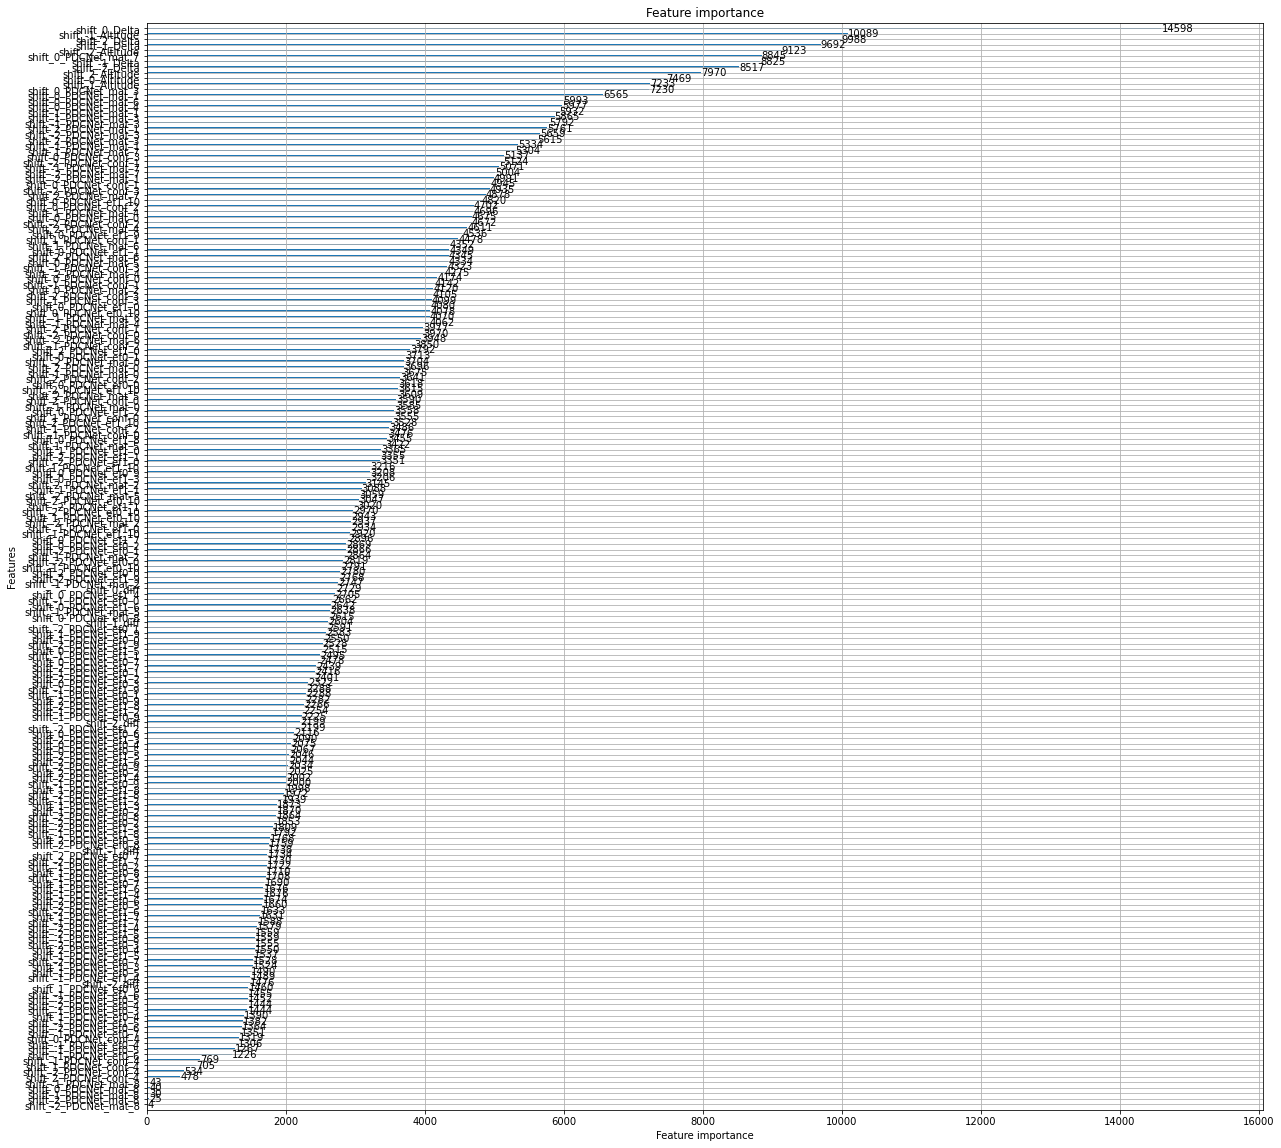

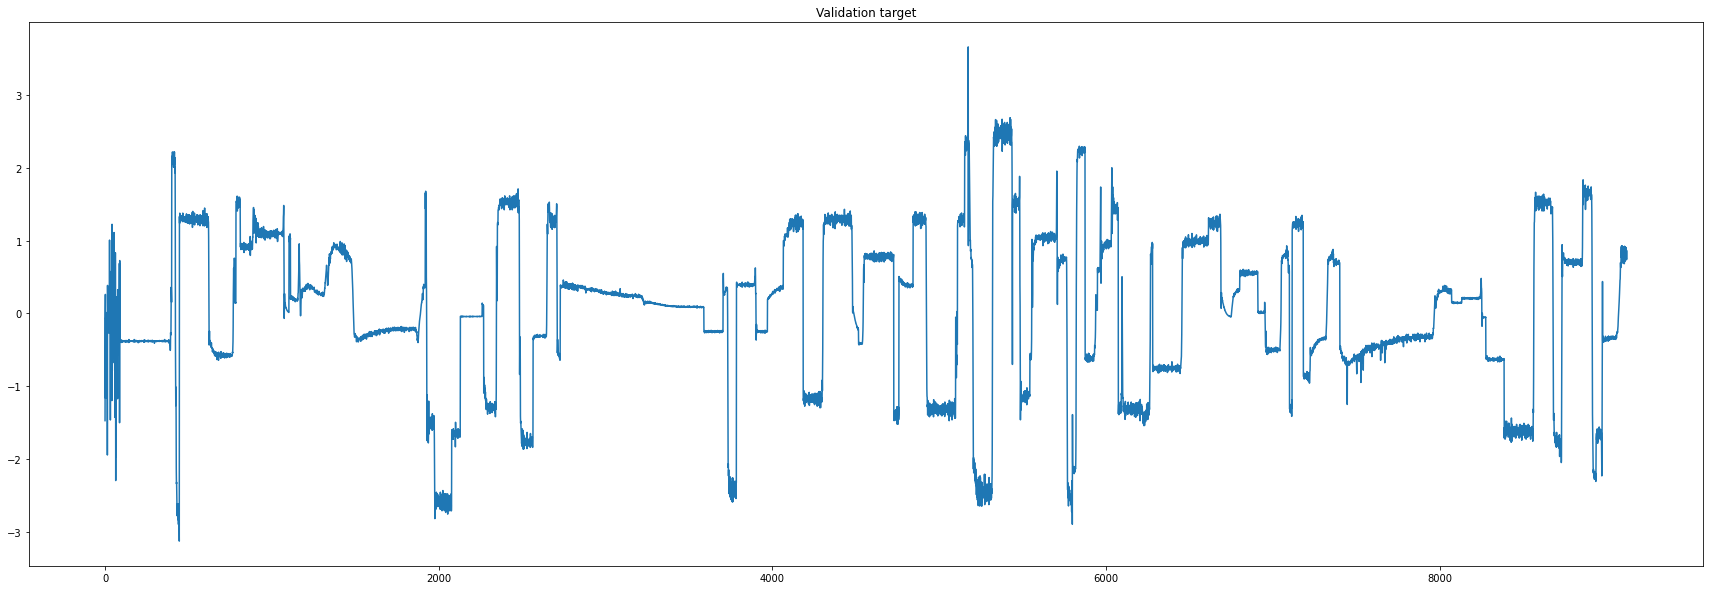

Rmse train  0.10882115375296342
Rmse val 0.2932477624036496


/tmp/ipykernel_10405/4231715049.py:23: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
/tmp/ipykernel_10405/4231715049.py:23: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
100%|████████████████████████████████| 410540/410540 [00:13<00:00, 30169.98it/s]


Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47642
[LightGBM] [Info] Number of data points in the train set: 82108, number of used features: 195
[LightGBM] [Info] Start training from score 0.003298
[1]	training's rmse: 1.17048	valid_1's rmse: 1.02727
[2]	training's rmse: 1.16516	valid_1's rmse: 1.02257
[3]	training's rmse: 1.15985	valid_1's rmse: 1.01787
[4]	training's rmse: 1.15456	valid_1's rmse: 1.0133
[5]	training's rmse: 1.14933	valid_1's rmse: 1.00866
[6]	training's rmse: 1.1441	valid_1's rmse: 1.00407
[7]	training's rmse: 1.13893	valid_1's rmse: 0.999554
[8]	training's rmse: 1.13376	valid_1's rmse: 0.995059
[9]	training's rmse: 1.12862	valid_1's rmse: 0.990634
[10]	training's rmse: 1.12353	valid_1's rmse: 0.98614
[11]	training's rmse: 1.11847	valid_1's rmse: 0.981658
[12]	training's rmse: 1.11342	valid_1's rmse:

[151]	training's rmse: 0.618399	valid_1's rmse: 0.551961
[152]	training's rmse: 0.616038	valid_1's rmse: 0.550017
[153]	training's rmse: 0.613684	valid_1's rmse: 0.548135
[154]	training's rmse: 0.611337	valid_1's rmse: 0.546127
[155]	training's rmse: 0.60902	valid_1's rmse: 0.544233
[156]	training's rmse: 0.606719	valid_1's rmse: 0.54238
[157]	training's rmse: 0.604382	valid_1's rmse: 0.540474
[158]	training's rmse: 0.602116	valid_1's rmse: 0.538607
[159]	training's rmse: 0.599852	valid_1's rmse: 0.536697
[160]	training's rmse: 0.597549	valid_1's rmse: 0.534792
[161]	training's rmse: 0.595289	valid_1's rmse: 0.53301
[162]	training's rmse: 0.593055	valid_1's rmse: 0.53121
[163]	training's rmse: 0.590793	valid_1's rmse: 0.529418
[164]	training's rmse: 0.588586	valid_1's rmse: 0.527599
[165]	training's rmse: 0.586374	valid_1's rmse: 0.525807
[166]	training's rmse: 0.584152	valid_1's rmse: 0.524055
[167]	training's rmse: 0.581979	valid_1's rmse: 0.522281
[168]	training's rmse: 0.579789	val

[308]	training's rmse: 0.37084	valid_1's rmse: 0.362738
[309]	training's rmse: 0.369871	valid_1's rmse: 0.362056
[310]	training's rmse: 0.36892	valid_1's rmse: 0.361418
[311]	training's rmse: 0.367947	valid_1's rmse: 0.360752
[312]	training's rmse: 0.366989	valid_1's rmse: 0.360123
[313]	training's rmse: 0.366032	valid_1's rmse: 0.359466
[314]	training's rmse: 0.36508	valid_1's rmse: 0.358902
[315]	training's rmse: 0.364151	valid_1's rmse: 0.35834
[316]	training's rmse: 0.36323	valid_1's rmse: 0.357655
[317]	training's rmse: 0.362314	valid_1's rmse: 0.357003
[318]	training's rmse: 0.361403	valid_1's rmse: 0.356338
[319]	training's rmse: 0.360487	valid_1's rmse: 0.355783
[320]	training's rmse: 0.359601	valid_1's rmse: 0.355175
[321]	training's rmse: 0.358684	valid_1's rmse: 0.3545
[322]	training's rmse: 0.357787	valid_1's rmse: 0.35393
[323]	training's rmse: 0.356895	valid_1's rmse: 0.35334
[324]	training's rmse: 0.356027	valid_1's rmse: 0.352774
[325]	training's rmse: 0.355175	valid_1'

[470]	training's rmse: 0.269825	valid_1's rmse: 0.301451
[471]	training's rmse: 0.269454	valid_1's rmse: 0.301265
[472]	training's rmse: 0.269089	valid_1's rmse: 0.301084
[473]	training's rmse: 0.268717	valid_1's rmse: 0.30091
[474]	training's rmse: 0.268357	valid_1's rmse: 0.300766
[475]	training's rmse: 0.267992	valid_1's rmse: 0.300606
[476]	training's rmse: 0.26764	valid_1's rmse: 0.300454
[477]	training's rmse: 0.267273	valid_1's rmse: 0.30025
[478]	training's rmse: 0.266908	valid_1's rmse: 0.300072
[479]	training's rmse: 0.266536	valid_1's rmse: 0.299871
[480]	training's rmse: 0.266173	valid_1's rmse: 0.299708
[481]	training's rmse: 0.26582	valid_1's rmse: 0.299554
[482]	training's rmse: 0.265459	valid_1's rmse: 0.299352
[483]	training's rmse: 0.265109	valid_1's rmse: 0.299258
[484]	training's rmse: 0.264748	valid_1's rmse: 0.299143
[485]	training's rmse: 0.264396	valid_1's rmse: 0.298938
[486]	training's rmse: 0.264051	valid_1's rmse: 0.298763
[487]	training's rmse: 0.263704	val

[621]	training's rmse: 0.22922	valid_1's rmse: 0.284351
[622]	training's rmse: 0.229036	valid_1's rmse: 0.284271
[623]	training's rmse: 0.228848	valid_1's rmse: 0.284211
[624]	training's rmse: 0.228653	valid_1's rmse: 0.284156
[625]	training's rmse: 0.228462	valid_1's rmse: 0.284098
[626]	training's rmse: 0.228276	valid_1's rmse: 0.28399
[627]	training's rmse: 0.228092	valid_1's rmse: 0.283924
[628]	training's rmse: 0.227905	valid_1's rmse: 0.283896
[629]	training's rmse: 0.227723	valid_1's rmse: 0.28381
[630]	training's rmse: 0.227539	valid_1's rmse: 0.283752
[631]	training's rmse: 0.227367	valid_1's rmse: 0.283716
[632]	training's rmse: 0.227173	valid_1's rmse: 0.28359
[633]	training's rmse: 0.226978	valid_1's rmse: 0.283534
[634]	training's rmse: 0.226797	valid_1's rmse: 0.283464
[635]	training's rmse: 0.226612	valid_1's rmse: 0.283421
[636]	training's rmse: 0.226431	valid_1's rmse: 0.28338
[637]	training's rmse: 0.226251	valid_1's rmse: 0.283275
[638]	training's rmse: 0.226069	vali

[775]	training's rmse: 0.206497	valid_1's rmse: 0.276332
[776]	training's rmse: 0.206377	valid_1's rmse: 0.276262
[777]	training's rmse: 0.206254	valid_1's rmse: 0.276184
[778]	training's rmse: 0.206136	valid_1's rmse: 0.276124
[779]	training's rmse: 0.206008	valid_1's rmse: 0.276063
[780]	training's rmse: 0.205889	valid_1's rmse: 0.276014
[781]	training's rmse: 0.205773	valid_1's rmse: 0.275956
[782]	training's rmse: 0.205657	valid_1's rmse: 0.275924
[783]	training's rmse: 0.205545	valid_1's rmse: 0.275862
[784]	training's rmse: 0.205426	valid_1's rmse: 0.275802
[785]	training's rmse: 0.205316	valid_1's rmse: 0.275784
[786]	training's rmse: 0.2052	valid_1's rmse: 0.275726
[787]	training's rmse: 0.205083	valid_1's rmse: 0.275673
[788]	training's rmse: 0.204959	valid_1's rmse: 0.27564
[789]	training's rmse: 0.204842	valid_1's rmse: 0.275605
[790]	training's rmse: 0.204735	valid_1's rmse: 0.275568
[791]	training's rmse: 0.204632	valid_1's rmse: 0.275557
[792]	training's rmse: 0.20452	val

[932]	training's rmse: 0.190694	valid_1's rmse: 0.271104
[933]	training's rmse: 0.190603	valid_1's rmse: 0.271072
[934]	training's rmse: 0.190513	valid_1's rmse: 0.271045
[935]	training's rmse: 0.190427	valid_1's rmse: 0.270994
[936]	training's rmse: 0.190337	valid_1's rmse: 0.270985
[937]	training's rmse: 0.190258	valid_1's rmse: 0.270981
[938]	training's rmse: 0.19016	valid_1's rmse: 0.270956
[939]	training's rmse: 0.190069	valid_1's rmse: 0.270918
[940]	training's rmse: 0.189989	valid_1's rmse: 0.270887
[941]	training's rmse: 0.189893	valid_1's rmse: 0.270866
[942]	training's rmse: 0.189806	valid_1's rmse: 0.270852
[943]	training's rmse: 0.189724	valid_1's rmse: 0.27085
[944]	training's rmse: 0.189637	valid_1's rmse: 0.270858
[945]	training's rmse: 0.189553	valid_1's rmse: 0.270846
[946]	training's rmse: 0.189465	valid_1's rmse: 0.270807
[947]	training's rmse: 0.18937	valid_1's rmse: 0.270796
[948]	training's rmse: 0.189286	valid_1's rmse: 0.27079
[949]	training's rmse: 0.189198	val

[1078]	training's rmse: 0.17925	valid_1's rmse: 0.267547
[1079]	training's rmse: 0.17918	valid_1's rmse: 0.267529
[1080]	training's rmse: 0.179111	valid_1's rmse: 0.267506
[1081]	training's rmse: 0.179047	valid_1's rmse: 0.267485
[1082]	training's rmse: 0.178974	valid_1's rmse: 0.267465
[1083]	training's rmse: 0.178906	valid_1's rmse: 0.267447
[1084]	training's rmse: 0.17884	valid_1's rmse: 0.267422
[1085]	training's rmse: 0.178777	valid_1's rmse: 0.267401
[1086]	training's rmse: 0.1787	valid_1's rmse: 0.267385
[1087]	training's rmse: 0.178632	valid_1's rmse: 0.26738
[1088]	training's rmse: 0.178558	valid_1's rmse: 0.267347
[1089]	training's rmse: 0.178487	valid_1's rmse: 0.26734
[1090]	training's rmse: 0.178423	valid_1's rmse: 0.267319
[1091]	training's rmse: 0.17835	valid_1's rmse: 0.267307
[1092]	training's rmse: 0.178281	valid_1's rmse: 0.267276
[1093]	training's rmse: 0.178216	valid_1's rmse: 0.267243
[1094]	training's rmse: 0.178142	valid_1's rmse: 0.267222
[1095]	training's rmse

[1225]	training's rmse: 0.170204	valid_1's rmse: 0.264797
[1226]	training's rmse: 0.170146	valid_1's rmse: 0.264785
[1227]	training's rmse: 0.170091	valid_1's rmse: 0.264784
[1228]	training's rmse: 0.170034	valid_1's rmse: 0.264762
[1229]	training's rmse: 0.169972	valid_1's rmse: 0.264757
[1230]	training's rmse: 0.169917	valid_1's rmse: 0.264739
[1231]	training's rmse: 0.169855	valid_1's rmse: 0.264739
[1232]	training's rmse: 0.169795	valid_1's rmse: 0.26473
[1233]	training's rmse: 0.169734	valid_1's rmse: 0.264727
[1234]	training's rmse: 0.16967	valid_1's rmse: 0.264714
[1235]	training's rmse: 0.169614	valid_1's rmse: 0.264701
[1236]	training's rmse: 0.169555	valid_1's rmse: 0.264677
[1237]	training's rmse: 0.169494	valid_1's rmse: 0.264673
[1238]	training's rmse: 0.169431	valid_1's rmse: 0.264655
[1239]	training's rmse: 0.169377	valid_1's rmse: 0.264655
[1240]	training's rmse: 0.169315	valid_1's rmse: 0.264635
[1241]	training's rmse: 0.169263	valid_1's rmse: 0.26463
[1242]	training's

[1372]	training's rmse: 0.16254	valid_1's rmse: 0.26302
[1373]	training's rmse: 0.162505	valid_1's rmse: 0.263014
[1374]	training's rmse: 0.162465	valid_1's rmse: 0.263009
[1375]	training's rmse: 0.162425	valid_1's rmse: 0.263001
[1376]	training's rmse: 0.162379	valid_1's rmse: 0.262995
[1377]	training's rmse: 0.162337	valid_1's rmse: 0.262993
[1378]	training's rmse: 0.162287	valid_1's rmse: 0.262988
[1379]	training's rmse: 0.162244	valid_1's rmse: 0.262991
[1380]	training's rmse: 0.162194	valid_1's rmse: 0.262982
[1381]	training's rmse: 0.162142	valid_1's rmse: 0.262961
[1382]	training's rmse: 0.162097	valid_1's rmse: 0.262951
[1383]	training's rmse: 0.162053	valid_1's rmse: 0.262909
[1384]	training's rmse: 0.162009	valid_1's rmse: 0.262893
[1385]	training's rmse: 0.161965	valid_1's rmse: 0.262885
[1386]	training's rmse: 0.161917	valid_1's rmse: 0.26288
[1387]	training's rmse: 0.161868	valid_1's rmse: 0.262879
[1388]	training's rmse: 0.16182	valid_1's rmse: 0.262869
[1389]	training's 

[1522]	training's rmse: 0.155788	valid_1's rmse: 0.261818
[1523]	training's rmse: 0.15574	valid_1's rmse: 0.261809
[1524]	training's rmse: 0.155691	valid_1's rmse: 0.2618
[1525]	training's rmse: 0.15565	valid_1's rmse: 0.261791
[1526]	training's rmse: 0.155608	valid_1's rmse: 0.261788
[1527]	training's rmse: 0.155566	valid_1's rmse: 0.26178
[1528]	training's rmse: 0.155528	valid_1's rmse: 0.261764
[1529]	training's rmse: 0.155475	valid_1's rmse: 0.261759
[1530]	training's rmse: 0.155422	valid_1's rmse: 0.261746
[1531]	training's rmse: 0.155386	valid_1's rmse: 0.261732
[1532]	training's rmse: 0.155342	valid_1's rmse: 0.261724
[1533]	training's rmse: 0.155299	valid_1's rmse: 0.26168
[1534]	training's rmse: 0.155269	valid_1's rmse: 0.26168
[1535]	training's rmse: 0.15524	valid_1's rmse: 0.26167
[1536]	training's rmse: 0.155194	valid_1's rmse: 0.261666
[1537]	training's rmse: 0.155146	valid_1's rmse: 0.261661
[1538]	training's rmse: 0.155098	valid_1's rmse: 0.261647
[1539]	training's rmse:

[1671]	training's rmse: 0.149855	valid_1's rmse: 0.26057
[1672]	training's rmse: 0.149816	valid_1's rmse: 0.260553
[1673]	training's rmse: 0.149774	valid_1's rmse: 0.260546
[1674]	training's rmse: 0.149738	valid_1's rmse: 0.260543
[1675]	training's rmse: 0.149701	valid_1's rmse: 0.260546
[1676]	training's rmse: 0.149667	valid_1's rmse: 0.260543
[1677]	training's rmse: 0.149635	valid_1's rmse: 0.260538
[1678]	training's rmse: 0.149605	valid_1's rmse: 0.260536
[1679]	training's rmse: 0.149569	valid_1's rmse: 0.260535
[1680]	training's rmse: 0.14953	valid_1's rmse: 0.260528
[1681]	training's rmse: 0.149493	valid_1's rmse: 0.260515
[1682]	training's rmse: 0.149456	valid_1's rmse: 0.260519
[1683]	training's rmse: 0.149414	valid_1's rmse: 0.260499
[1684]	training's rmse: 0.149378	valid_1's rmse: 0.260494
[1685]	training's rmse: 0.149336	valid_1's rmse: 0.260482
[1686]	training's rmse: 0.149295	valid_1's rmse: 0.260475
[1687]	training's rmse: 0.149257	valid_1's rmse: 0.260474
[1688]	training'

[1822]	training's rmse: 0.144402	valid_1's rmse: 0.260087
[1823]	training's rmse: 0.144369	valid_1's rmse: 0.260085
[1824]	training's rmse: 0.144326	valid_1's rmse: 0.260074
[1825]	training's rmse: 0.144289	valid_1's rmse: 0.260078
[1826]	training's rmse: 0.144242	valid_1's rmse: 0.260066
[1827]	training's rmse: 0.144213	valid_1's rmse: 0.260056
[1828]	training's rmse: 0.144181	valid_1's rmse: 0.260038
[1829]	training's rmse: 0.144145	valid_1's rmse: 0.260022
[1830]	training's rmse: 0.144111	valid_1's rmse: 0.260012
[1831]	training's rmse: 0.144075	valid_1's rmse: 0.260007
[1832]	training's rmse: 0.144039	valid_1's rmse: 0.260016
[1833]	training's rmse: 0.143999	valid_1's rmse: 0.260013
[1834]	training's rmse: 0.143965	valid_1's rmse: 0.260013
[1835]	training's rmse: 0.143934	valid_1's rmse: 0.26001
[1836]	training's rmse: 0.143908	valid_1's rmse: 0.260001
[1837]	training's rmse: 0.143881	valid_1's rmse: 0.259998
[1838]	training's rmse: 0.143854	valid_1's rmse: 0.259999
[1839]	training

[1972]	training's rmse: 0.139424	valid_1's rmse: 0.259557
[1973]	training's rmse: 0.139391	valid_1's rmse: 0.259547
[1974]	training's rmse: 0.139356	valid_1's rmse: 0.25955
[1975]	training's rmse: 0.139324	valid_1's rmse: 0.259545
[1976]	training's rmse: 0.139298	valid_1's rmse: 0.259538
[1977]	training's rmse: 0.139269	valid_1's rmse: 0.259528
[1978]	training's rmse: 0.139241	valid_1's rmse: 0.259524
[1979]	training's rmse: 0.139209	valid_1's rmse: 0.259528
[1980]	training's rmse: 0.139175	valid_1's rmse: 0.259528
[1981]	training's rmse: 0.139133	valid_1's rmse: 0.259534
[1982]	training's rmse: 0.139094	valid_1's rmse: 0.259526
[1983]	training's rmse: 0.139059	valid_1's rmse: 0.259518
[1984]	training's rmse: 0.13903	valid_1's rmse: 0.259516
[1985]	training's rmse: 0.138993	valid_1's rmse: 0.259513
[1986]	training's rmse: 0.138956	valid_1's rmse: 0.259507
[1987]	training's rmse: 0.138921	valid_1's rmse: 0.259498
[1988]	training's rmse: 0.138892	valid_1's rmse: 0.259504
[1989]	training'

[2123]	training's rmse: 0.134716	valid_1's rmse: 0.259065
[2124]	training's rmse: 0.134688	valid_1's rmse: 0.259055
[2125]	training's rmse: 0.134658	valid_1's rmse: 0.259054
[2126]	training's rmse: 0.134627	valid_1's rmse: 0.259048
[2127]	training's rmse: 0.1346	valid_1's rmse: 0.259037
[2128]	training's rmse: 0.134576	valid_1's rmse: 0.259034
[2129]	training's rmse: 0.134553	valid_1's rmse: 0.25902
[2130]	training's rmse: 0.134525	valid_1's rmse: 0.259015
[2131]	training's rmse: 0.134499	valid_1's rmse: 0.259017
[2132]	training's rmse: 0.134471	valid_1's rmse: 0.25901
[2133]	training's rmse: 0.134439	valid_1's rmse: 0.259007
[2134]	training's rmse: 0.134415	valid_1's rmse: 0.259011
[2135]	training's rmse: 0.134391	valid_1's rmse: 0.259011
[2136]	training's rmse: 0.134359	valid_1's rmse: 0.259025
[2137]	training's rmse: 0.13433	valid_1's rmse: 0.259027
[2138]	training's rmse: 0.134304	valid_1's rmse: 0.259029
[2139]	training's rmse: 0.134278	valid_1's rmse: 0.259027
[2140]	training's r

[2273]	training's rmse: 0.130392	valid_1's rmse: 0.258718
[2274]	training's rmse: 0.130359	valid_1's rmse: 0.25872
[2275]	training's rmse: 0.130328	valid_1's rmse: 0.258713
[2276]	training's rmse: 0.130298	valid_1's rmse: 0.258714
[2277]	training's rmse: 0.130265	valid_1's rmse: 0.258714
[2278]	training's rmse: 0.130237	valid_1's rmse: 0.258713
[2279]	training's rmse: 0.130214	valid_1's rmse: 0.258713
[2280]	training's rmse: 0.130185	valid_1's rmse: 0.258716
[2281]	training's rmse: 0.130163	valid_1's rmse: 0.25871
[2282]	training's rmse: 0.130143	valid_1's rmse: 0.258706
[2283]	training's rmse: 0.130118	valid_1's rmse: 0.258705
[2284]	training's rmse: 0.130095	valid_1's rmse: 0.258696
[2285]	training's rmse: 0.130074	valid_1's rmse: 0.258697
[2286]	training's rmse: 0.130054	valid_1's rmse: 0.258691
[2287]	training's rmse: 0.130028	valid_1's rmse: 0.258679
[2288]	training's rmse: 0.130001	valid_1's rmse: 0.258667
[2289]	training's rmse: 0.129978	valid_1's rmse: 0.258664
[2290]	training'

[2424]	training's rmse: 0.126246	valid_1's rmse: 0.25859
[2425]	training's rmse: 0.126212	valid_1's rmse: 0.258582
[2426]	training's rmse: 0.126178	valid_1's rmse: 0.258596
[2427]	training's rmse: 0.126149	valid_1's rmse: 0.258605
[2428]	training's rmse: 0.126126	valid_1's rmse: 0.258616
[2429]	training's rmse: 0.126098	valid_1's rmse: 0.258622
[2430]	training's rmse: 0.126065	valid_1's rmse: 0.258638
[2431]	training's rmse: 0.126028	valid_1's rmse: 0.258659
[2432]	training's rmse: 0.125993	valid_1's rmse: 0.258662
[2433]	training's rmse: 0.125961	valid_1's rmse: 0.258679
[2434]	training's rmse: 0.125931	valid_1's rmse: 0.258687
[2435]	training's rmse: 0.125904	valid_1's rmse: 0.258684
[2436]	training's rmse: 0.125874	valid_1's rmse: 0.25871
[2437]	training's rmse: 0.125838	valid_1's rmse: 0.258706
[2438]	training's rmse: 0.125816	valid_1's rmse: 0.258701
[2439]	training's rmse: 0.125794	valid_1's rmse: 0.258696
[2440]	training's rmse: 0.125772	valid_1's rmse: 0.25869
[2441]	training's

[2575]	training's rmse: 0.122512	valid_1's rmse: 0.258356
[2576]	training's rmse: 0.12249	valid_1's rmse: 0.25835
[2577]	training's rmse: 0.122466	valid_1's rmse: 0.258353
[2578]	training's rmse: 0.122444	valid_1's rmse: 0.258346
[2579]	training's rmse: 0.12242	valid_1's rmse: 0.25834
[2580]	training's rmse: 0.122395	valid_1's rmse: 0.258342
[2581]	training's rmse: 0.122372	valid_1's rmse: 0.258331
[2582]	training's rmse: 0.122348	valid_1's rmse: 0.258324
[2583]	training's rmse: 0.122324	valid_1's rmse: 0.258314
[2584]	training's rmse: 0.122299	valid_1's rmse: 0.258311
[2585]	training's rmse: 0.122273	valid_1's rmse: 0.258312
[2586]	training's rmse: 0.122245	valid_1's rmse: 0.258301
[2587]	training's rmse: 0.122212	valid_1's rmse: 0.258303
[2588]	training's rmse: 0.122189	valid_1's rmse: 0.258298
[2589]	training's rmse: 0.122155	valid_1's rmse: 0.258283
[2590]	training's rmse: 0.122134	valid_1's rmse: 0.258275
[2591]	training's rmse: 0.122113	valid_1's rmse: 0.258275
[2592]	training's 

[2725]	training's rmse: 0.118858	valid_1's rmse: 0.257975
[2726]	training's rmse: 0.118829	valid_1's rmse: 0.257975
[2727]	training's rmse: 0.118805	valid_1's rmse: 0.257975
[2728]	training's rmse: 0.118785	valid_1's rmse: 0.257973
[2729]	training's rmse: 0.11876	valid_1's rmse: 0.257971
[2730]	training's rmse: 0.118738	valid_1's rmse: 0.257967
[2731]	training's rmse: 0.118716	valid_1's rmse: 0.257962
[2732]	training's rmse: 0.118689	valid_1's rmse: 0.257955
[2733]	training's rmse: 0.118665	valid_1's rmse: 0.257954
[2734]	training's rmse: 0.118646	valid_1's rmse: 0.257946
[2735]	training's rmse: 0.118625	valid_1's rmse: 0.257944
[2736]	training's rmse: 0.118604	valid_1's rmse: 0.257938
[2737]	training's rmse: 0.118581	valid_1's rmse: 0.257936
[2738]	training's rmse: 0.118557	valid_1's rmse: 0.257933
[2739]	training's rmse: 0.118526	valid_1's rmse: 0.257941
[2740]	training's rmse: 0.118504	valid_1's rmse: 0.25794
[2741]	training's rmse: 0.118482	valid_1's rmse: 0.257928
[2742]	training'

[2879]	training's rmse: 0.115262	valid_1's rmse: 0.257676
[2880]	training's rmse: 0.115241	valid_1's rmse: 0.257675
[2881]	training's rmse: 0.115213	valid_1's rmse: 0.257692
[2882]	training's rmse: 0.115191	valid_1's rmse: 0.257717
[2883]	training's rmse: 0.115172	valid_1's rmse: 0.257743
[2884]	training's rmse: 0.115146	valid_1's rmse: 0.257773
[2885]	training's rmse: 0.115121	valid_1's rmse: 0.2578
[2886]	training's rmse: 0.115101	valid_1's rmse: 0.257812
[2887]	training's rmse: 0.115074	valid_1's rmse: 0.257814
[2888]	training's rmse: 0.115052	valid_1's rmse: 0.257809
[2889]	training's rmse: 0.115031	valid_1's rmse: 0.257813
[2890]	training's rmse: 0.11501	valid_1's rmse: 0.257827
[2891]	training's rmse: 0.114982	valid_1's rmse: 0.257837
[2892]	training's rmse: 0.114963	valid_1's rmse: 0.25784
[2893]	training's rmse: 0.114938	valid_1's rmse: 0.257846
[2894]	training's rmse: 0.114914	valid_1's rmse: 0.257833
[2895]	training's rmse: 0.114888	valid_1's rmse: 0.257831
[2896]	training's 

[3032]	training's rmse: 0.111916	valid_1's rmse: 0.257674
[3033]	training's rmse: 0.111902	valid_1's rmse: 0.257671
[3034]	training's rmse: 0.111871	valid_1's rmse: 0.257675
[3035]	training's rmse: 0.11185	valid_1's rmse: 0.257659
[3036]	training's rmse: 0.111824	valid_1's rmse: 0.257665
[3037]	training's rmse: 0.111804	valid_1's rmse: 0.257667
[3038]	training's rmse: 0.111783	valid_1's rmse: 0.257667
[3039]	training's rmse: 0.111757	valid_1's rmse: 0.257673
[3040]	training's rmse: 0.111729	valid_1's rmse: 0.257675
[3041]	training's rmse: 0.111712	valid_1's rmse: 0.257669
[3042]	training's rmse: 0.111697	valid_1's rmse: 0.257669
[3043]	training's rmse: 0.111679	valid_1's rmse: 0.257671
[3044]	training's rmse: 0.111664	valid_1's rmse: 0.257673
[3045]	training's rmse: 0.111642	valid_1's rmse: 0.257667
[3046]	training's rmse: 0.111622	valid_1's rmse: 0.257657
[3047]	training's rmse: 0.111599	valid_1's rmse: 0.257652
[3048]	training's rmse: 0.111579	valid_1's rmse: 0.257654
[3049]	training

[3185]	training's rmse: 0.108859	valid_1's rmse: 0.257353
[3186]	training's rmse: 0.108838	valid_1's rmse: 0.257355
[3187]	training's rmse: 0.108814	valid_1's rmse: 0.257345
[3188]	training's rmse: 0.108796	valid_1's rmse: 0.257342
[3189]	training's rmse: 0.108775	valid_1's rmse: 0.257339
[3190]	training's rmse: 0.108754	valid_1's rmse: 0.257335
[3191]	training's rmse: 0.108733	valid_1's rmse: 0.257332
[3192]	training's rmse: 0.108711	valid_1's rmse: 0.257331
[3193]	training's rmse: 0.108689	valid_1's rmse: 0.25733
[3194]	training's rmse: 0.108671	valid_1's rmse: 0.257326
[3195]	training's rmse: 0.10865	valid_1's rmse: 0.257325
[3196]	training's rmse: 0.108634	valid_1's rmse: 0.257322
[3197]	training's rmse: 0.108618	valid_1's rmse: 0.25732
[3198]	training's rmse: 0.108601	valid_1's rmse: 0.257322
[3199]	training's rmse: 0.108585	valid_1's rmse: 0.257321
[3200]	training's rmse: 0.108567	valid_1's rmse: 0.257325
[3201]	training's rmse: 0.108546	valid_1's rmse: 0.257325
[3202]	training's

[3336]	training's rmse: 0.105884	valid_1's rmse: 0.257101
[3337]	training's rmse: 0.105861	valid_1's rmse: 0.257099
[3338]	training's rmse: 0.105836	valid_1's rmse: 0.257107
[3339]	training's rmse: 0.105815	valid_1's rmse: 0.257104
[3340]	training's rmse: 0.105791	valid_1's rmse: 0.257103
[3341]	training's rmse: 0.105775	valid_1's rmse: 0.257097
[3342]	training's rmse: 0.105758	valid_1's rmse: 0.257097
[3343]	training's rmse: 0.105745	valid_1's rmse: 0.257093
[3344]	training's rmse: 0.105733	valid_1's rmse: 0.257096
[3345]	training's rmse: 0.10572	valid_1's rmse: 0.257095
[3346]	training's rmse: 0.105698	valid_1's rmse: 0.257095
[3347]	training's rmse: 0.105671	valid_1's rmse: 0.257101
[3348]	training's rmse: 0.10564	valid_1's rmse: 0.257099
[3349]	training's rmse: 0.105618	valid_1's rmse: 0.257102
[3350]	training's rmse: 0.105597	valid_1's rmse: 0.257107
[3351]	training's rmse: 0.10558	valid_1's rmse: 0.257099
[3352]	training's rmse: 0.105563	valid_1's rmse: 0.257092
[3353]	training's

[3485]	training's rmse: 0.103195	valid_1's rmse: 0.256828
[3486]	training's rmse: 0.103182	valid_1's rmse: 0.256829
[3487]	training's rmse: 0.103167	valid_1's rmse: 0.256822
[3488]	training's rmse: 0.103152	valid_1's rmse: 0.256818
[3489]	training's rmse: 0.103139	valid_1's rmse: 0.256815
[3490]	training's rmse: 0.103123	valid_1's rmse: 0.25681
[3491]	training's rmse: 0.103099	valid_1's rmse: 0.256805
[3492]	training's rmse: 0.103078	valid_1's rmse: 0.256802
[3493]	training's rmse: 0.103057	valid_1's rmse: 0.256789
[3494]	training's rmse: 0.103038	valid_1's rmse: 0.256793
[3495]	training's rmse: 0.10302	valid_1's rmse: 0.256789
[3496]	training's rmse: 0.102997	valid_1's rmse: 0.256784
[3497]	training's rmse: 0.102976	valid_1's rmse: 0.25678
[3498]	training's rmse: 0.102961	valid_1's rmse: 0.256782
[3499]	training's rmse: 0.102945	valid_1's rmse: 0.256777
[3500]	training's rmse: 0.102926	valid_1's rmse: 0.256772
[3501]	training's rmse: 0.102902	valid_1's rmse: 0.256771
[3502]	training's

[3635]	training's rmse: 0.100592	valid_1's rmse: 0.256688
[3636]	training's rmse: 0.100569	valid_1's rmse: 0.256689
[3637]	training's rmse: 0.100548	valid_1's rmse: 0.256693
[3638]	training's rmse: 0.10053	valid_1's rmse: 0.256695
[3639]	training's rmse: 0.100508	valid_1's rmse: 0.256702
[3640]	training's rmse: 0.10049	valid_1's rmse: 0.256697
[3641]	training's rmse: 0.100473	valid_1's rmse: 0.256697
[3642]	training's rmse: 0.10046	valid_1's rmse: 0.256697
[3643]	training's rmse: 0.100447	valid_1's rmse: 0.2567
[3644]	training's rmse: 0.100432	valid_1's rmse: 0.25669
[3645]	training's rmse: 0.100417	valid_1's rmse: 0.256684
[3646]	training's rmse: 0.100397	valid_1's rmse: 0.256683
[3647]	training's rmse: 0.10038	valid_1's rmse: 0.256678
[3648]	training's rmse: 0.100363	valid_1's rmse: 0.256676
[3649]	training's rmse: 0.100349	valid_1's rmse: 0.256674
[3650]	training's rmse: 0.100331	valid_1's rmse: 0.256669
[3651]	training's rmse: 0.100316	valid_1's rmse: 0.256665
[3652]	training's rms

[3788]	training's rmse: 0.0980318	valid_1's rmse: 0.25674
[3789]	training's rmse: 0.0980153	valid_1's rmse: 0.256737
[3790]	training's rmse: 0.0979986	valid_1's rmse: 0.256735
[3791]	training's rmse: 0.0979802	valid_1's rmse: 0.256737
[3792]	training's rmse: 0.0979609	valid_1's rmse: 0.256741
[3793]	training's rmse: 0.0979397	valid_1's rmse: 0.256754
[3794]	training's rmse: 0.0979186	valid_1's rmse: 0.256748
[3795]	training's rmse: 0.0978982	valid_1's rmse: 0.256751
[3796]	training's rmse: 0.0978781	valid_1's rmse: 0.256753
[3797]	training's rmse: 0.0978568	valid_1's rmse: 0.256749
[3798]	training's rmse: 0.0978382	valid_1's rmse: 0.256751
[3799]	training's rmse: 0.0978208	valid_1's rmse: 0.25675
[3800]	training's rmse: 0.0978005	valid_1's rmse: 0.256748
[3801]	training's rmse: 0.0977849	valid_1's rmse: 0.256748
[3802]	training's rmse: 0.0977686	valid_1's rmse: 0.256748
[3803]	training's rmse: 0.0977481	valid_1's rmse: 0.256746
[3804]	training's rmse: 0.0977307	valid_1's rmse: 0.256738

[3940]	training's rmse: 0.0955475	valid_1's rmse: 0.256782
[3941]	training's rmse: 0.0955339	valid_1's rmse: 0.256782
[3942]	training's rmse: 0.0955201	valid_1's rmse: 0.256782
[3943]	training's rmse: 0.0955054	valid_1's rmse: 0.256777
[3944]	training's rmse: 0.0954944	valid_1's rmse: 0.256781
[3945]	training's rmse: 0.0954832	valid_1's rmse: 0.256779
[3946]	training's rmse: 0.0954646	valid_1's rmse: 0.256789
[3947]	training's rmse: 0.0954496	valid_1's rmse: 0.256785
[3948]	training's rmse: 0.0954362	valid_1's rmse: 0.256779
[3949]	training's rmse: 0.0954174	valid_1's rmse: 0.256779
[3950]	training's rmse: 0.0953982	valid_1's rmse: 0.256772
[3951]	training's rmse: 0.0953759	valid_1's rmse: 0.25677
[3952]	training's rmse: 0.0953549	valid_1's rmse: 0.256771
[3953]	training's rmse: 0.0953306	valid_1's rmse: 0.256771
[3954]	training's rmse: 0.0953121	valid_1's rmse: 0.256771
[3955]	training's rmse: 0.0952963	valid_1's rmse: 0.256769
[3956]	training's rmse: 0.0952805	valid_1's rmse: 0.25676

[4090]	training's rmse: 0.0932196	valid_1's rmse: 0.256602
[4091]	training's rmse: 0.0932009	valid_1's rmse: 0.256616
[4092]	training's rmse: 0.0931842	valid_1's rmse: 0.256623
[4093]	training's rmse: 0.0931704	valid_1's rmse: 0.256622
[4094]	training's rmse: 0.093156	valid_1's rmse: 0.256623
[4095]	training's rmse: 0.0931398	valid_1's rmse: 0.256642
[4096]	training's rmse: 0.0931236	valid_1's rmse: 0.256644
[4097]	training's rmse: 0.0931089	valid_1's rmse: 0.25664
[4098]	training's rmse: 0.093097	valid_1's rmse: 0.256637
[4099]	training's rmse: 0.093081	valid_1's rmse: 0.256637
[4100]	training's rmse: 0.0930664	valid_1's rmse: 0.256636
[4101]	training's rmse: 0.093059	valid_1's rmse: 0.256637
[4102]	training's rmse: 0.0930488	valid_1's rmse: 0.256636
[4103]	training's rmse: 0.0930411	valid_1's rmse: 0.256633
[4104]	training's rmse: 0.0930258	valid_1's rmse: 0.256632
[4105]	training's rmse: 0.093012	valid_1's rmse: 0.256631
[4106]	training's rmse: 0.0930001	valid_1's rmse: 0.25663
[410

[4242]	training's rmse: 0.0910577	valid_1's rmse: 0.256534
[4243]	training's rmse: 0.0910412	valid_1's rmse: 0.256549
[4244]	training's rmse: 0.0910217	valid_1's rmse: 0.256554
[4245]	training's rmse: 0.091006	valid_1's rmse: 0.256545
[4246]	training's rmse: 0.0909924	valid_1's rmse: 0.256544
[4247]	training's rmse: 0.0909812	valid_1's rmse: 0.25654
[4248]	training's rmse: 0.0909671	valid_1's rmse: 0.256534
[4249]	training's rmse: 0.090953	valid_1's rmse: 0.256533
[4250]	training's rmse: 0.0909418	valid_1's rmse: 0.256532
[4251]	training's rmse: 0.0909285	valid_1's rmse: 0.256527
[4252]	training's rmse: 0.090915	valid_1's rmse: 0.256516
[4253]	training's rmse: 0.0909014	valid_1's rmse: 0.256517
[4254]	training's rmse: 0.0908845	valid_1's rmse: 0.256518
[4255]	training's rmse: 0.090873	valid_1's rmse: 0.256518
[4256]	training's rmse: 0.0908587	valid_1's rmse: 0.256514
[4257]	training's rmse: 0.0908437	valid_1's rmse: 0.256507
[4258]	training's rmse: 0.0908307	valid_1's rmse: 0.256501
[4

[4393]	training's rmse: 0.0888886	valid_1's rmse: 0.256416
[4394]	training's rmse: 0.088874	valid_1's rmse: 0.256411
[4395]	training's rmse: 0.0888582	valid_1's rmse: 0.256407
[4396]	training's rmse: 0.0888448	valid_1's rmse: 0.256408
[4397]	training's rmse: 0.0888296	valid_1's rmse: 0.256403
[4398]	training's rmse: 0.0888145	valid_1's rmse: 0.256396
[4399]	training's rmse: 0.0887999	valid_1's rmse: 0.256395
[4400]	training's rmse: 0.0887851	valid_1's rmse: 0.256391
[4401]	training's rmse: 0.0887659	valid_1's rmse: 0.256387
[4402]	training's rmse: 0.088746	valid_1's rmse: 0.256382
[4403]	training's rmse: 0.0887274	valid_1's rmse: 0.25638
[4404]	training's rmse: 0.0887094	valid_1's rmse: 0.256377
[4405]	training's rmse: 0.0886913	valid_1's rmse: 0.256374
[4406]	training's rmse: 0.0886782	valid_1's rmse: 0.256375
[4407]	training's rmse: 0.0886648	valid_1's rmse: 0.256372
[4408]	training's rmse: 0.0886509	valid_1's rmse: 0.256369
[4409]	training's rmse: 0.0886375	valid_1's rmse: 0.25637
[

[4546]	training's rmse: 0.0868623	valid_1's rmse: 0.256366
[4547]	training's rmse: 0.0868518	valid_1's rmse: 0.256364
[4548]	training's rmse: 0.0868396	valid_1's rmse: 0.256359
[4549]	training's rmse: 0.0868277	valid_1's rmse: 0.256356
[4550]	training's rmse: 0.0868162	valid_1's rmse: 0.256355
[4551]	training's rmse: 0.086796	valid_1's rmse: 0.256352
[4552]	training's rmse: 0.0867834	valid_1's rmse: 0.256349
[4553]	training's rmse: 0.0867702	valid_1's rmse: 0.256346
[4554]	training's rmse: 0.0867553	valid_1's rmse: 0.256344
[4555]	training's rmse: 0.0867368	valid_1's rmse: 0.256345
[4556]	training's rmse: 0.0867213	valid_1's rmse: 0.256347
[4557]	training's rmse: 0.0867055	valid_1's rmse: 0.256348
[4558]	training's rmse: 0.0866923	valid_1's rmse: 0.256349
[4559]	training's rmse: 0.0866792	valid_1's rmse: 0.256344
[4560]	training's rmse: 0.0866659	valid_1's rmse: 0.256346
[4561]	training's rmse: 0.0866544	valid_1's rmse: 0.256338
[4562]	training's rmse: 0.0866428	valid_1's rmse: 0.25633

[4698]	training's rmse: 0.0848432	valid_1's rmse: 0.256138
[4699]	training's rmse: 0.0848304	valid_1's rmse: 0.256136
[4700]	training's rmse: 0.0848136	valid_1's rmse: 0.256135
[4701]	training's rmse: 0.0848007	valid_1's rmse: 0.256136
[4702]	training's rmse: 0.0847891	valid_1's rmse: 0.256134
[4703]	training's rmse: 0.084776	valid_1's rmse: 0.256135
[4704]	training's rmse: 0.0847637	valid_1's rmse: 0.256132
[4705]	training's rmse: 0.0847501	valid_1's rmse: 0.256134
[4706]	training's rmse: 0.0847349	valid_1's rmse: 0.256133
[4707]	training's rmse: 0.0847198	valid_1's rmse: 0.256134
[4708]	training's rmse: 0.0847111	valid_1's rmse: 0.256131
[4709]	training's rmse: 0.0847023	valid_1's rmse: 0.256123
[4710]	training's rmse: 0.0846954	valid_1's rmse: 0.256124
[4711]	training's rmse: 0.0846852	valid_1's rmse: 0.256125
[4712]	training's rmse: 0.0846768	valid_1's rmse: 0.256122
[4713]	training's rmse: 0.0846677	valid_1's rmse: 0.256123
[4714]	training's rmse: 0.0846579	valid_1's rmse: 0.25612

[4851]	training's rmse: 0.083008	valid_1's rmse: 0.256176
[4852]	training's rmse: 0.0829952	valid_1's rmse: 0.256179
[4853]	training's rmse: 0.0829819	valid_1's rmse: 0.256177
[4854]	training's rmse: 0.0829696	valid_1's rmse: 0.256178
[4855]	training's rmse: 0.0829554	valid_1's rmse: 0.256176
[4856]	training's rmse: 0.0829447	valid_1's rmse: 0.256174
[4857]	training's rmse: 0.0829294	valid_1's rmse: 0.256179
[4858]	training's rmse: 0.0829125	valid_1's rmse: 0.256182
[4859]	training's rmse: 0.0829018	valid_1's rmse: 0.256177
[4860]	training's rmse: 0.0828892	valid_1's rmse: 0.256176
[4861]	training's rmse: 0.0828768	valid_1's rmse: 0.256172
[4862]	training's rmse: 0.082867	valid_1's rmse: 0.256173
[4863]	training's rmse: 0.0828525	valid_1's rmse: 0.256172
[4864]	training's rmse: 0.0828424	valid_1's rmse: 0.256172
[4865]	training's rmse: 0.0828335	valid_1's rmse: 0.256173
[4866]	training's rmse: 0.0828207	valid_1's rmse: 0.256171
[4867]	training's rmse: 0.0828111	valid_1's rmse: 0.256168

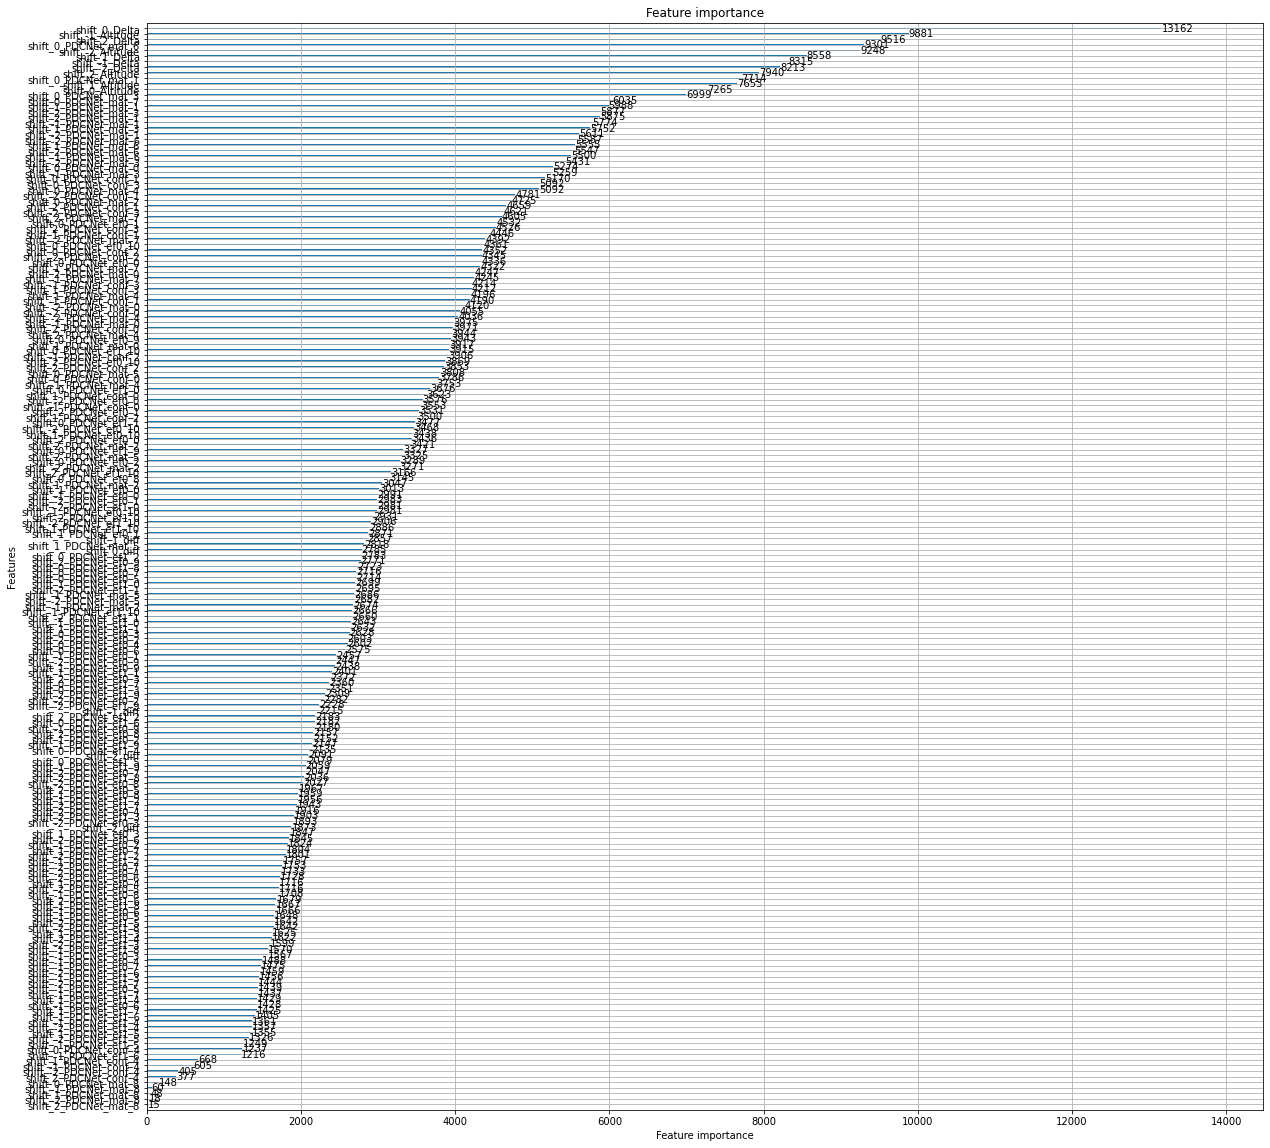

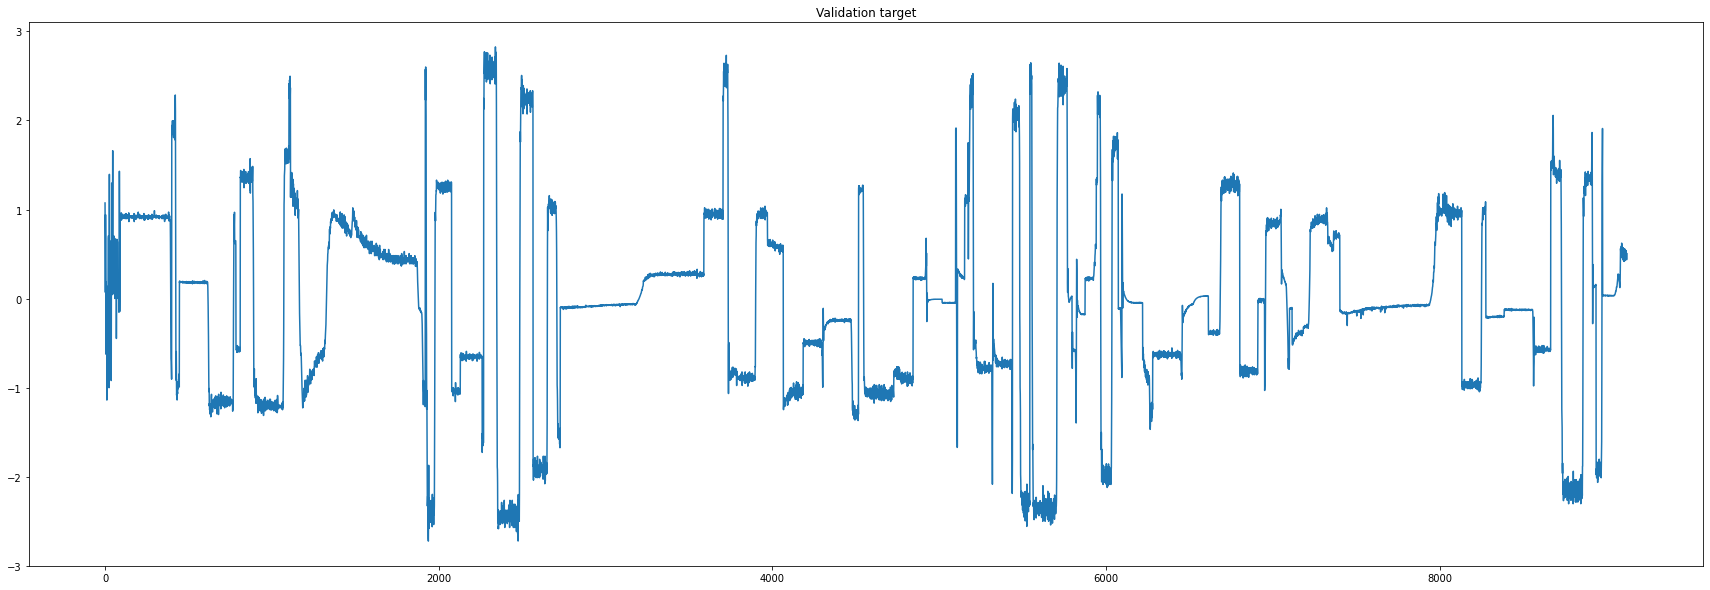

Rmse train  0.08125227346354219
Rmse val 0.256079966669436


In [28]:
#!pip install lightgbm 
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import trange
def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))


def get_flight_df(mode):
    if mode == 'train' or mode == 'trainval':
        return pd.read_csv(osp.join(ROOT_FOLDER,'flight','flight_train.csv'))
    elif mode == 'test':
        return pd.read_csv(osp.join(ROOT_FOLDER,'flight','flight_test.csv'))
    else:
        raise ValueError('Invalid value for parameter "mode"')

def get_feature_df(mode):
    sub_names = ['PDCNet']
    cnames = []
    for sub in sub_names:
        cols = list(pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')).columns)
        cnames += [sub+ '_' + x for x in cols]
    feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
    feat_df.columns = cnames
    return feat_df

def get_lgb_dataframe(mode):
        feat_df = get_feature_df(mode)
        feat_df['Filename'] = dfs[mode]['Filename']

        if mode == 'trainval':
            flight_df = get_flight_df('train')
        else:
            flight_df = get_flight_df('test')
        flight_df['step_is_neg'] = np.array((flight_df['step'].values == -1)).astype(np.float32)

        # Merge
        df = flight_df.copy()
        df = df.merge(feat_df, on='Filename').reset_index(drop=True)

        feat_df = feat_df.drop('Filename',axis=1)

        df_Y = df.loc[:,['North','East']].copy()
        df_X = df.loc[:,['Altitude','Delta', 'diff','step_is_neg'] + list(feat_df.columns) ]
        def shift(df, n):
            #assert n>= 0
            df = df.shift(-n)
            #display(df)
            df.columns = [f'shift_{n}_{c}' for c in df.columns]
            return df
        df_X = pd.concat([shift(df_X,i) for i in [-1,-2, 0, 1, 2]], axis=1)
        return df, df_X, df_Y



def calc_lgb(target_var):
    
    

    train_df, train_df_X, train_df_Y = get_lgb_dataframe('trainval')
    
    test_df, test_df_X, test_df_Y = get_lgb_dataframe('test')

    N_val = train_df_X.shape[0] // 10
    val_idx = np.arange(train_df_X.shape[0])[:N_val]#np.where(np.arange(feat_df.shape[0]) < N_val)[0]
    train_idx = np.arange(train_df_X.shape[0])[N_val:] #= np.where(np.arange(feat_df.shape[0]) >= N_val)[0]

    X_trainval, Y_trainval = train_df_X.copy(), train_df_Y[target_var].copy()

    X_train, Y_train = train_df_X.iloc[train_idx,:].copy(), train_df_Y.iloc[train_idx,:][target_var].copy()
    
    """ Create augmentation. """
    X_train_inv = X_train.copy()
    import re
    mat_cols = [c for c in X_train.columns if re.search('_mat_',c) is not None]
    ef_cols = [c for c in X_train.columns if re.search('ef.*_mean',c) is not None]
    altitude_cols = [c for c in X_train.columns if re.search('Altitude',c) is not None]
    delta_cols = [c for c in X_train.columns if re.search('Delta',c) is not None]
    M = X_train.loc[:,mat_cols].fillna(1).values.reshape(-1,3,3)
    from scipy import linalg
    for i in trange(M.shape[0]):
        M[i,:] = linalg.pinv(M[i,:])
    X_train_inv.loc[:,mat_cols] = M.reshape(-1,len(mat_cols))
    alt = X_train_inv[altitude_cols].values
    delta = X_train_inv[delta_cols].values
    X_train_inv[altitude_cols] = alt + delta
    X_train_inv[delta_cols] = -delta
    X_train_inv[ef_cols] = -1 * X_train_inv[ef_cols].values
    
    #X_train = pd.concat([X_train,X_train_inv],axis=0, ignore_index=True)
    #Y_train = pd.concat([Y_train,-1 * Y_train],axis=0, ignore_index=True)
    
    """ Create validation, test matrices"""
    X_val, Y_val = train_df_X.iloc[val_idx,:].copy(), train_df_Y.iloc[val_idx,:][target_var].copy()
    X_test, Y_test = test_df_X, test_df_Y[target_var].copy()

    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)


    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'num_leaves': 128,
        'metric_freq': 10,
        'learning_rate': 0.005,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'verbose': 1
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000,
                    valid_sets=[lgb_train,lgb_eval])
    fig, ax = plt.subplots(figsize=(20,20))
    lgb.plot_importance(gbm, ax=ax)
    plt.show()
    
    
    
    train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
    val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    fig, ax = plt.subplots(1, figsize=(30,10))
    ax.set_title('Validation target')
    ax.plot(np.arange(val_pred.shape[0]), Y_val)
    plt.show()
    
    """
    fig, ax = plt.subplots(1, figsize=(30,10))
    ax.set_title('Validation prediction')
    ax.plot(np.arange(val_pred.shape[0]), val_pred)
    plt.show()
    ax.set_title('Validation target')
    ax.plot(np.arange(val_pred.shape[0]), Y_val)
    plt.show()

    fig, ax = plt.subplots(1, figsize=(30,10))
    ax.set_title('Validation error')
    ax.plot(np.arange(val_pred.shape[0]), val_pred-Y_val)
    plt.show()
    """
    
    
    print("Rmse train ",rmse(train_pred, Y_train.values))
    print("Rmse val",rmse(val_pred, Y_val.values))

    test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    
    
    
    #trainval_pred = trainval_pred[np.argsort(train_df['Filename'])] 
    test_pred = test_pred[np.argsort(test_df['Filename'])] 
    
    return val_pred, test_pred, gbm

# Train Lightgbm model for North and East predictions separately.
val_north, test_north, gbm_north = calc_lgb('North')
val_east, test_east, gbm_east = calc_lgb('East')

#print('Saving model...'

In [ ]:
import matplotlib.pyplot as plt


def get_flight_df(mode):
    if mode == 'train' or mode == 'trainval':
        return pd.read_csv(osp.join(ROOT_FOLDER,'flight','flight_train.csv'))
    elif mode == 'test':
        return pd.read_csv(osp.join(ROOT_FOLDER,'flight','flight_test.csv'))
    else:
        raise ValueError('Invalid value for parameter "mode"')
        


        
plt.plot(np.arange(val_north.shape), val_north)



/tmp/ipykernel_4648/3935961014.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
  0%|                                                 | 0/91231 [00:00<?, ?it/s]

[[[162 165 122]
  [165 165 103]
  [191 192 132]
  ...
  [140 146 162]
  [150 153 168]
  [156 160 172]]

 [[157 160 117]
  [171 171 109]
  [190 191 131]
  ...
  [139 145 161]
  [151 154 169]
  [157 161 173]]

 [[163 166 123]
  [162 162 100]
  [188 189 129]
  ...
  [139 145 159]
  [154 158 170]
  [160 164 175]]

 ...

 [[161 163 100]
  [165 168  99]
  [170 173 104]
  ...
  [167 171  94]
  [168 171  94]
  [170 173  96]]

 [[165 167 104]
  [169 170 102]
  [172 174 101]
  ...
  [167 170  93]
  [169 172  95]
  [172 175  96]]

 [[169 169 107]
  [168 169  99]
  [167 169  96]
  ...
  [169 172  95]
  [174 177  98]
  [176 179 100]]]


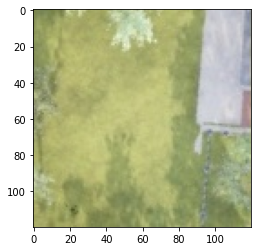

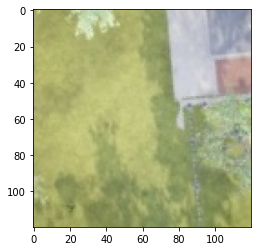

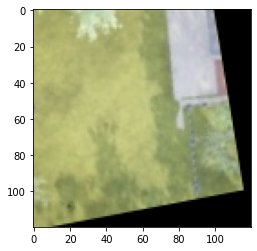

,Unnamed: 0,Filename,Altitude,Delta,North,East,step,diff,NewAlt,step_is_neg,...,pdcplus_cm_mean,pdcplus_ef0_mean,pdcplus_ef0_std,pdcplus_ef1_mean,pdcplus_ef1_std,pdcplus_cm_q0,pdcplus_cm_q1,pdcplus_cm_q2,pdcplus_cm_q3,pdcplus_cm_q4
0,59522,a74d1ff33e951286f8b41bd995f0c5e0.jpg,166.561401,0.140137,-1.472750,1.073440,-1,0.000000,166.701538,1.0,...,0.553256,10.434282,6.086181,9.726435,6.216383,0.156562,0.516644,0.571110,0.572862,0.572872
1,50788,8eee11ee7ca63d411e87ee6a74745788.jpg,224.052460,-0.058441,-0.059471,0.650216,-1,0.000000,223.994019,1.0,...,0.572831,2.520085,0.568902,0.231656,0.102395,0.506454,0.572865,0.572870,0.572871,0.572872
2,50948,8f55c4078dea0f611692ed797b76d511.jpg,182.064758,0.116028,0.260522,0.070070,-1,0.000000,182.180786,1.0,...,0.548515,1.401495,1.034235,-4.033319,3.074700,0.040105,0.535637,0.571513,0.572810,0.572872
3,51018,8f861a68d4d8f8ba0125e0a1a658b9c7.jpg,230.827515,0.081451,-1.165959,0.941549,-1,0.000000,230.908966,1.0,...,0.558895,9.821801,2.810941,20.815617,2.802990,0.172595,0.529088,0.572221,0.572870,0.572872
4,36116,655c4f29723a697c4873fbbdc66ddbdf.jpg,223.877167,-0.060501,-0.057968,0.670597,-1,0.000000,223.816666,1.0,...,0.572827,2.314426,0.526161,0.233882,0.085959,0.486313,0.572868,0.572871,0.572872,0.572872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91226,21588,3c2a0c5e5ecf4c43f503e936bb8e70f3.jpg,174.220734,0.118698,1.010115,0.593155,91137,0.222748,174.339432,0.0,...,0.570858,5.300654,1.822848,-8.757746,1.781814,0.397491,0.572013,0.572866,0.572871,0.572872
91227,74228,d10bcc3e56fbc08cd7d07e74314ed528.jpg,174.058472,0.162262,0.893986,0.754980,91138,0.280960,174.220734,0.0,...,0.569977,6.580373,0.651300,-11.973396,0.668521,0.308695,0.568679,0.572865,0.572871,0.572872
91228,90537,fe0ee9a28fabdb1c977ceca9c473b4ff.jpg,173.841064,0.217407,0.722605,0.654151,91139,0.379669,174.058472,0.0,...,0.568176,11.609554,6.007128,-14.621451,5.890863,0.135784,0.566442,0.572825,0.572869,0.572872
91229,8029,1647786da9f34e8690fbd08db3484ad1.jpg,173.497986,0.343079,0.817771,0.129055,91140,0.560486,173.841064,0.0,...,0.567042,14.182343,2.858749,-13.962459,2.673300,0.145396,0.557818,0.572731,0.572869,0.572872


  0%|                                                 | 0/91231 [00:00<?, ?it/s]


TypeError: exceptions must derive from BaseException

In [90]:
import os
import os.path as osp
import cv2 as cv

import matplotlib.pyplot as plt
from PIL import Image
df_train, X_train, _ = get_lgb_dataframe('trainval')
import re
mat_cols = [c for c in X_train.columns if re.search('_mat_',c) is not None]
L = []
for i in trange(feat_df.shape[0]):

    M = X_train.loc[i,mat_cols].values.reshape(3,3)

    
    fname = df_train['Filename'].values[i]
    path = osp.join(DS_FOLDER,'train','train',fname)
    img = np.array(Image.open(path))
    src, dst = img[:,:120,:], img[:,120:,:]
    h,w,_ = src.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    #dst = cv.perspectiveTransform(pts,M)
    warped_src = cv.warpPerspective(src,M, dsize=(h,w))
    print(dst)
    
    
    plt.imshow(src)
    plt.show()
    plt.imshow(dst)
    plt.show()
    plt.imshow(warped_src)
    plt.show()

    display(df_train)
    raise ''
    
    a =  M @ (np.array([60, 60, 1]).reshape(-1,1))
    b =  M @ (np.array([0, 0, 1]).reshape(-1,1))
    a, b = a.reshape(-1), b.reshape(-1)
    
    a = a/[-1]
    b = b/[-1]
    #print(a)
    
    target  = df_train['North'].values[i]
    L.append([a[2], target])
    if i == 1000:
        break
    
plt.scatter([x[0] for x in L],[x[1] for x in L] )
plt.show()
    

NameError: name 'Y_val' is not defined

In [34]:
display(dfs['trainval'])
print(trainval_north)
print(rmse(dfs['trainval']['North'].values, trainval_north))
#print(np.mean(np.square(trainval_north  - dfs['trainval']['North'].values)))
#print(np.sqrt(np.mean(np.square(trainval_north - dfs['trainval']['North'].values))))

,Filename,Altitude,Delta,North,East
0,00003e3b9e5336685200ae85d21b4f5e.jpg,178.829834,-0.065231,-0.386045,0.929772
1,0001261e2060303a06ba6c64d676d639.jpg,207.921478,-0.080688,0.635584,0.152819
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,178.048431,0.021576,-1.228229,-0.499388
3,0004289ee1c7b8b08c77e19878106ae3.jpg,201.084625,0.505981,-1.739709,-0.699928
4,0004d0b59e19461ff126e3a08a814c33.jpg,187.550201,-0.328156,-0.169798,2.828752
...,...,...,...,...,...
91226,fffe56994e6be696722539f962415cd2.jpg,156.505661,-0.102219,2.143182,-1.334290
91227,fffe9f664c2ddba4a37bcd35936c7422.jpg,176.796066,0.045807,-1.329934,-0.138351
91228,fffee5badc626a2ab8086120712e5639.jpg,173.157288,-0.003067,1.023046,-2.311214
91229,ffffda8ada4827900cbf65fd20281080.jpg,205.024994,0.005096,2.476233,-0.172700


[-0.35896244  0.62936525 -1.15244423 ...  0.98298428  2.42135712
  0.62014761]
0.11997440639852601


In [29]:

PREDICTION_NAME = input("Give a name to this prediction")
pred_folder = osp.join(ROOT_FOLDER,'predictions', PREDICTION_NAME)
os.makedirs(pred_folder,exist_ok=True)

for mode, df_N, df_E in [('test',test_north, test_east)]:
    df = pd.DataFrame(index=range(2 * dfs[mode].shape[0]), columns=['Id','Predicted'])
    df['Id'].values[::2] = [f'{fname}:North' for fname in dfs[mode]['Filename'].values] 
    df['Id'].values[1::2] = [f'{fname}:East' for fname in dfs[mode]['Filename'].values] 
    df['Predicted'].values[::2] = df_N
    df['Predicted'].values[1::2] = df_E
    df.to_csv(osp.join(pred_folder,f'{mode}.csv'),index=False)
    
    gbm_north.save_model(osp.join(pred_folder,f'gbm_north.txt'))
    gbm_east.save_model(osp.join(pred_folder,f'gbm_east.txt'))
    
    display(df)
    

Give a name to this predictionOct23_lgb_2


,Id,Predicted
0,000053b1e684c9e7ea73727b2238ce18.jpg:North,0.060855
1,000053b1e684c9e7ea73727b2238ce18.jpg:East,-0.053234
2,00029153d12ae1c9abe59c17ff2e0895.jpg:North,1.012301
3,00029153d12ae1c9abe59c17ff2e0895.jpg:East,-0.79711
4,0006246bee639c7a7b11a08e34dd3cc6.jpg:North,-1.8684
...,...,...
110057,fff9e3be29d11366c43df7b2ae749547.jpg:East,1.088788
110058,fffae68750a8bd5e6ba46b25ce7030de.jpg:North,-0.749167
110059,fffae68750a8bd5e6ba46b25ce7030de.jpg:East,-1.695573
110060,fffaee1d19b93f046ff12095b5c56685.jpg:North,0.61303
